In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [2]:
import xy

In [362]:
import imp
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\UMR\\xy.py'>

# $因子描述：UMR$

***计算每个标的换手率多头组合的收益率，即标的放量收益率和缩量收益率之差***  
从个股上看，换手多空动量是一个空头指标，这意味着过去20日内，**出现放量下跌且缩量上涨的标的更有可能在次日上涨**，而在指数强弱上体现了相反的规律，以此为切入点改进“个股 —— 指数”的映射方式。

1. 数据：股票日线行情、换手率  
2. 滚动20日，使用换手率最高的5日，和换手最低的五日收益率作为样本，分别计算其收益率均值得到 arr5 和 arr1；
3. arr5-arr1得到换手多空动量。
4. **在映射到指数的过程中，剔除中间噪声标的**

## 计算

In [4]:
TR300 = (pd.concat([
    (xy.index_high.T['300'] - xy.index_low.T['300']),
    (xy.index_high.T['300'] - xy.cl.T['300'].shift(1)).abs(),
    (xy.cl.T['300'].shift(1) - xy.index_low.T['300']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('300')/xy.cl.T['300']
TR50 = (pd.concat([
    (xy.index_high.T['50'] - xy.index_low.T['50']),
    (xy.index_high.T['50'] - xy.cl.T['50'].shift(1)).abs(),
    (xy.cl.T['50'].shift(1) - xy.index_low.T['50']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('50')/xy.cl.T['50']
TR500 = (pd.concat([
    (xy.index_high.T['500'] - xy.index_low.T['500']),
    (xy.index_high.T['500'] - xy.cl.T['500'].shift(1)).abs(),
    (xy.cl.T['500'].shift(1) - xy.index_low.T['500']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('500')/xy.cl.T['500']
TR1000 = (pd.concat([
    (xy.index_high.T['1000'] - xy.index_low.T['1000']),
    (xy.index_high.T['1000'] - xy.cl.T['1000'].shift(1)).abs(),
    (xy.cl.T['1000'].shift(1) - xy.index_low.T['1000']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('1000')/xy.cl.T['1000']
# ATR300 = TR.rolling(15).mean().dropna()

In [132]:
DN = (xy.cl - xy.op) / xy.op
ON = (xy.op - xy.cl.shift(axis=1)) / xy.cl.shift(axis=1)
# ATR300 = TR.rolling(15).mean().dropna()

In [136]:
xy.op

2002-12-31  2003-01-02  2003-01-03  2003-01-06  2003-01-07  2003-01-08  \
50            0.0      0.0000       0.000      0.0000        0.00       0.000   
300           0.0      0.0000       0.000      0.0000        0.00       0.000   
500           0.0      0.0000       0.000      0.0000        0.00       0.000   
1000          0.0      0.0000       0.000      0.0000        0.00       0.000   
sz100      1000.0    975.9475     976.358    990.4533      988.97    1017.123   
kc50          0.0      0.0000       0.000      0.0000        0.00       0.000   
2000          0.0      0.0000       0.000      0.0000        0.00       0.000   

       2003-01-09  2003-01-10  2003-01-13  2003-01-14  ...  2023-04-24  \
50         0.0000      0.0000      0.0000       0.000  ...   2655.0845   
300        0.0000      0.0000      0.0000       0.000  ...   4031.3030   
500        0.0000      0.0000      0.0000       0.000  ...   6250.9635   
1000       0.0000      0.0000      0.0000       0.000  ...   6766.5182   
sz100   1035.5459   1023.3844   1028.8913    1088.048  ...   5146.2321   
kc50       0.0000      0.0000      0.0000       0.000  ...   1116.6656   
2000       0.0000      0.0000      0.0000       0.000  ...   8190.1044   

       2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
50      2621.0217   2614.9585   2618.4568   2653.1382   2663.4516   2698.5897   
300     3985.1055   3950.2553   3948.0313   3993.2561   4013.4713   4031.0946   
500     6205.6184   6095.1335   6127.6444   6151.6433   6223.2261   6255.7044   
1000    6708.2779   6577.3592   6597.7306   6617.3249   6701.4906   6723.1596   
sz100   5072.9719   4993.0058   5022.7548   5086.9605   5096.5250   5051.9005   
kc50    1095.9456   1072.6959   1063.5302   1060.7062   1077.8519   1062.6626   
2000    8145.3477   7975.7825   8033.5745   8024.4121   8173.8419   8219.5052   

       2023-05-08  2023-05-09  2023-05-10  
50      2694.5675   2723.1877   2698.7661  
300     4028.1056   4065.4390   4017.9358  
500     6202.6787   6242.6615   6167.1346  
1000    6660.9166   6696.6682   6599.7879  
sz100   5050.6781   5038.4292   4998.0261  
kc50    1050.0999   1058.3730   1031.1290  
2000    8154.4073   8189.1674   8054.1513  

[7 rows x 4942 columns]

In [134]:
DN.T[['50', '300', '500', '1000']].dropna()

50       300       500      1000
2005-01-04 -0.011848 -0.012039 -0.009787 -0.006318
2005-01-05  0.006929  0.011190  0.017295  0.023953
2005-01-06 -0.011406 -0.010224 -0.008864 -0.009360
2005-01-07  0.001151  0.000924  0.004200  0.006191
2005-01-10  0.011192  0.010286  0.009438  0.011575
...              ...       ...       ...       ...
2023-05-04  0.010978  0.004180  0.006293  0.004847
2023-05-05 -0.004972 -0.003527 -0.008813 -0.010338
2023-05-08  0.009558  0.008579  0.007401  0.006243
2023-05-09 -0.007069 -0.009240 -0.009721 -0.012698
2023-05-10 -0.009212 -0.005243  0.001082  0.004170

[4457 rows x 4 columns]

In [7]:
ATR = pd.DataFrame([
    TR300.dropna(),
    TR500.dropna(),
    TR50.dropna(),
    TR1000.dropna()
])

In [8]:
ATR = ATR.T.sort_index().shift(0).dropna()

In [9]:
STD = xy.cl.pct_change(axis=1).T.rolling(20,min_periods=1).std().loc[:,['50', '300', '500', '1000']]

In [11]:
Risk = (ATR.shift(0).rolling(20).mean() - ATR).dropna().T

In [546]:
xy.Index_rets.loc[['50', '300', '500', '1000'],:]

2002-12-31  2003-01-02  2003-01-03  2003-01-06  2003-01-07  2003-01-08  \
50           NaN         NaN         NaN         NaN         NaN         NaN   
300          NaN         NaN         NaN         NaN         NaN         NaN   
500          NaN         NaN         NaN         NaN         NaN         NaN   
1000         NaN         NaN         NaN         NaN         NaN         NaN   

      2003-01-09  2003-01-10  2003-01-13  2003-01-14  ...  2023-07-24  \
50           NaN         NaN         NaN         NaN  ...   -0.003703   
300          NaN         NaN         NaN         NaN  ...   -0.004367   
500          NaN         NaN         NaN         NaN  ...   -0.001504   
1000         NaN         NaN         NaN         NaN  ...   -0.001191   

      2023-07-25  2023-07-26  2023-07-27  2023-07-28  2023-07-31  2023-08-01  \
50      0.031341   -0.000761   -0.000398    0.027828    0.002394   -0.002818   
300     0.028880   -0.002070   -0.001195    0.023163    0.005483   -0.004142   
500     0.016887   -0.002508   -0.006724    0.013766    0.007446    0.001747   
1000    0.016340   -0.006312   -0.007698    0.009025    0.007807   -0.001295   

      2023-08-02  2023-08-03  2023-08-04  
50     -0.009527    0.009337    0.001396  
300    -0.007030    0.008839    0.003894  
500    -0.003511    0.003492    0.004898  
1000   -0.001750    0.000542    0.005505  

[4 rows x 5002 columns]

In [549]:
mean_ret = xy.rets.mean()

In [575]:
exR = (xy.Index_rets.loc[['50', '300', '500', '1000'],:].T).apply(lambda x: x-mean_ret).T

In [576]:
exR.T.dropna().T

2015-01-06  2015-01-07  2015-01-08  2015-01-09  2015-01-12  2015-01-13  \
50     -0.024418    0.002909   -0.025939    0.011030    0.004582   -0.021387   
300    -0.016913    0.001442   -0.019871    0.003242    0.005032   -0.014956   
500    -0.005178    0.002221   -0.004727    0.000339    0.000173   -0.001422   
1000    0.003486   -0.000219    0.002897    0.000908    0.003652    0.002205   

      2015-01-14  2015-01-15  2015-01-16  2015-01-19  ...  2023-05-24  \
50      0.007014    0.030296   -0.004675   -0.061602  ...   -0.014170   
300     0.001176    0.020402   -0.003718   -0.047095  ...   -0.012637   
500    -0.000209    0.004247    0.000719   -0.013228  ...   -0.006519   
1000   -0.000030   -0.003851    0.001197    0.007090  ...   -0.001152   

      2023-05-25  2023-05-26  2023-05-29  2023-05-30  2023-05-31  2023-06-01  \
50     -0.003921   -0.006929    0.000107   -0.009281   -0.014422   -0.000217   
300    -0.001167   -0.004905    0.000116   -0.003130   -0.008152   -0.000829   
500    -0.001871    0.002793    0.002905    0.001876   -0.000164   -0.002416   
1000   -0.000810    0.001963    0.002655    0.000521    0.001635   -0.001023   

      2023-06-02  2023-06-05  2023-06-06  
50      0.009032   -0.009750    0.015754  
300     0.006178   -0.008337    0.010010  
500     0.000623   -0.005112    0.000751  
1000   -0.000424   -0.002776   -0.002184  

[4 rows x 2048 columns]

In [13]:
DNexR = (DN.loc[['50', '300', '500', '1000']].T).apply(lambda x: x-DN.loc[['50', '300', '500', '1000']].T.mean(axis=1)).dropna().T
ONexR = (ON.loc[['50', '300', '500', '1000']].T).apply(lambda x: x-ON.loc[['50', '300', '500', '1000']].T.mean(axis=1)).dropna().T

In [ ]:
f = (Risk.T * (exR.loc[['50', '300', '500', '1000'],:]).T).dropna(how='all',axis=0).T

In [ ]:
DN.loc[['50', '300', '500', '1000'],:].T.dropna()

In [ ]:
Risk.T.plot()

In [ ]:
def UMR(x,m=60,h=30):
    ws = []
    
    sum_buttom = sum([2**(-i/h) for i in range(len(x))])
    for j in range(len(x)):
        ws.append((2**(-(m-j+1)/h))/sum_buttom)
    
    # display(sum_buttom,sum(ws[:]))
    return np.nansum(np.array(ws) * x)

In [ ]:
ART_UMR = f.T.shift(1).rolling(60).apply(UMR).T.loc[['50', '300', '500', '1000'],'2016-02-28':]

In [ ]:
risk_qt = Risk.rolling(5000,min_periods=1).apply(lambda x :x.rank(ascending=False)[-1]/len(x))

In [ ]:
Risk

In [ ]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    (xy.Index_rets).T.rolling(20,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    group_num=4,
    masks=1
)[:].cumsum().plot()

In [1852]:
(DNexR - DN.T.rolling(20).mean().T.loc[['50', '300', '500', '1000'],:]).T.dropna().T

2005-01-31  2005-02-01  2005-02-02  2005-02-03  2005-02-04  2005-02-16  \
50      0.014454    0.008790   -0.006864    0.003219    0.003432   -0.008630   
300     0.009204    0.006126   -0.003514    0.002027    0.000078   -0.004059   
500    -0.004735   -0.001104    0.002776   -0.001735   -0.002545    0.004032   
1000   -0.010093   -0.006468    0.006966   -0.003048   -0.004353    0.006901   

      2005-02-17  2005-02-18  2005-02-21  2005-02-22  ...  2023-04-24  \
50     -0.010731   -0.004307   -0.002332   -0.012959  ...   -0.002646   
300    -0.005854   -0.001849   -0.002140   -0.006517  ...   -0.001799   
500     0.006240    0.002037   -0.000515    0.002317  ...    0.003441   
1000    0.009151    0.005417    0.002860    0.008288  ...    0.004099   

      2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
50      0.009586   -0.002380    0.004114   -0.002858    0.003757    0.001515   
300     0.004129   -0.001873    0.001839   -0.003499   -0.002799    0.003538   
500    -0.003803    0.003756   -0.003106    0.002022   -0.000493   -0.001143   
1000   -0.005250    0.003207   -0.002574    0.003267   -0.002002   -0.002572   

      2023-05-08  2023-05-09  2023-05-10  
50      0.000850    0.002172   -0.006559  
300     0.000526    0.000950   -0.001851  
500    -0.000203    0.001020    0.004748  
1000   -0.001214   -0.001482    0.008195  

[4 rows x 4438 columns]

In [563]:
exR.T.dropna().rolling(12,min_periods=1).apply(lambda x:x.mean()/x.std()).T

2015-01-06  2015-01-07  2015-01-08  2015-01-09  2015-01-12  2015-01-13  \
50           NaN   -0.556582   -0.974267   -0.482635   -0.364976   -0.529096   
300          NaN   -0.596020   -1.020317   -0.665764   -0.452596   -0.615161   
500          NaN   -0.282681   -0.617595   -0.498499   -0.432829   -0.483206   
1000         NaN    0.623399    1.031858    1.025499    1.251040    1.405078   

      2015-01-14  2015-01-15  2015-01-16  2015-01-19  ...  2023-05-24  \
50     -0.401533   -0.099227   -0.121856   -0.318700  ...   -0.429906   
300    -0.538143   -0.186975   -0.209889   -0.384943  ...   -0.532193   
500    -0.458096   -0.177922   -0.140944   -0.344610  ...   -0.707594   
1000    1.133598    0.449945    0.484095    0.596077  ...   -0.789602   

      2023-05-25  2023-05-26  2023-05-29  2023-05-30  2023-05-31  2023-06-01  \
50     -0.611021   -0.567765   -0.476594   -0.528633   -0.855046   -0.993527   
300    -0.694384   -0.646845   -0.545891   -0.540977   -0.877775   -0.979737   
500    -1.025691   -0.733738   -0.497710   -0.425068   -0.526032   -0.574306   
1000   -0.975290   -0.723067   -0.448550   -0.325207   -0.231819   -0.164750   

      2023-06-02  2023-06-05  2023-06-06  
50     -0.617809   -0.642066   -0.312776  
300    -0.632059   -0.653223   -0.340668  
500    -0.428215   -0.449708   -0.351285  
1000   -0.063469   -0.155320   -0.314238  

[4 rows x 2048 columns]

-0.01798916215905407
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

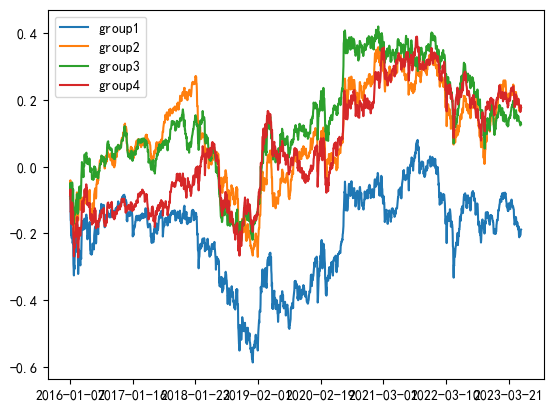

In [607]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    exR.T.dropna().rolling(12,min_periods=1).apply(lambda x:(x.skew())).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # exR.T.dropna().rolling(12,min_periods=1).apply(lambda x:x.std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    
    # (DNexR).T.rolling(1,min_periods=1).apply(lambda x:x[-1] ).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # (DNexR - DN.T.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-01-07':]).T.dropna().T.shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-01-07':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

In [616]:
import pymannkendall

In [672]:
DNexR.round(2)

2005-01-04  2005-01-05  2005-01-06  2005-01-07  2005-01-10  2005-01-11  \
50          -0.0       -0.01        -0.0        -0.0         0.0         0.0   
300         -0.0       -0.00        -0.0        -0.0        -0.0        -0.0   
500          0.0        0.00         0.0         0.0        -0.0        -0.0   
1000         0.0        0.01         0.0         0.0         0.0        -0.0   

      2005-01-12  2005-01-13  2005-01-14  2005-01-17  ...  2023-04-24  \
50           0.0        -0.0        0.00         0.0  ...        -0.0   
300          0.0        -0.0        0.00         0.0  ...        -0.0   
500          0.0         0.0       -0.00        -0.0  ...         0.0   
1000        -0.0         0.0       -0.01        -0.0  ...         0.0   

      2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
50          0.01        -0.0         0.0        -0.0         0.0         0.0   
300         0.00        -0.0         0.0        -0.0        -0.0         0.0   
500        -0.01         0.0        -0.0         0.0        -0.0        -0.0   
1000       -0.01         0.0        -0.0         0.0        -0.0        -0.0   

      2023-05-08  2023-05-09  2023-05-10  
50           0.0         0.0       -0.01  
300          0.0         0.0       -0.00  
500         -0.0        -0.0        0.00  
1000        -0.0        -0.0        0.01  

[4 rows x 4457 columns]

In [642]:
mk50 = DNexR.T['500'].rolling(12,min_periods=12).apply(lambda x:pymannkendall.__mk_score(x,12))

In [669]:
mk12 = (DNexR).T.rolling(12,min_periods=12).apply(lambda x:pymannkendall.__variance_s(x.round(2),12)).T

In [670]:
mk12

2005-01-04  2005-01-05  2005-01-06  2005-01-07  2005-01-10  2005-01-11  \
50           NaN         NaN         NaN         NaN         NaN         NaN   
300          NaN         NaN         NaN         NaN         NaN         NaN   
500          NaN         NaN         NaN         NaN         NaN         NaN   
1000         NaN         NaN         NaN         NaN         NaN         NaN   

      2005-01-12  2005-01-13  2005-01-14  2005-01-17  ...  2023-04-24  \
50           NaN         NaN         NaN         NaN  ...  143.666667   
300          NaN         NaN         NaN         NaN  ...    0.000000   
500          NaN         NaN         NaN         NaN  ...    0.000000   
1000         NaN         NaN         NaN         NaN  ...   47.666667   

      2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
50    159.666667  143.666667  143.666667  117.000000   86.666667   86.666667   
300     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
500    47.666667   47.666667   47.666667   47.666667   47.666667   47.666667   
1000   86.666667   86.666667   86.666667   86.666667   86.666667   86.666667   

      2023-05-08  2023-05-09  2023-05-10  
50     47.666667   47.666667   87.666667  
300     0.000000    0.000000    0.000000  
500    47.666667   47.666667   47.666667  
1000   47.666667   47.666667   87.666667  

[4 rows x 4457 columns]

-0.016469535195564013
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

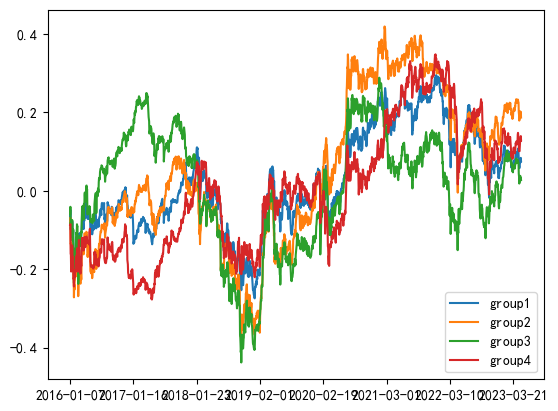

In [673]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    mk12.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # (xy.index_tov/xy.index_tov.shift(axis=1)).T.rolling(5).mean().T.shift(1,axis=1).loc[['50', '300', '500', '1000'],'2016-02-28':],
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-01-07':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

0.05427600336637732
1 0.9994574064026045
2 0.9994574064026045
3 0.9994574064026045
4 0.9994574064026045


<Axes: >

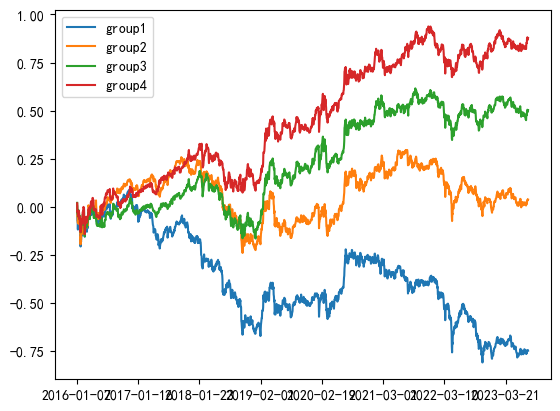

In [138]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    ((xy.index_tov/xy.index_tov.shift(axis=1)).shift(1,axis=1)*(exR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[:,'2016-01-07':].shift(1,axis=1)).loc[:,'2016-01-07':],
    # (xy.index_tov/xy.index_tov.shift(axis=1)).T.rolling(5).mean().T.shift(1,axis=1).loc[['50', '300', '500', '1000'],'2016-02-28':],
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2006-02-28':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

<Axes: >

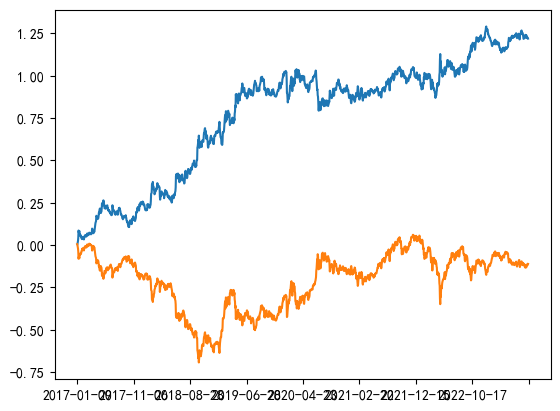

In [506]:
(DNM_select1.loc['1000'] * xy.Index_rets.loc[ '1000','2017-01-07':'2023-12-07']).cumsum().plot()
xy.Index_rets.loc[ '1000','2017-01-07':'2023-12-07'].cumsum().plot()

In [612]:
DNM_rets1

2016-01-07    0.028723
2016-01-08    0.015664
2016-01-11    0.030837
2016-01-12    0.007343
2016-01-13    0.030836
                ...   
2023-07-31         NaN
2023-08-01         NaN
2023-08-02         NaN
2023-08-03         NaN
2023-08-04         NaN
Length: 1843, dtype: float64

694.0
yoy: 0.2917802811722209 
 mdd: -0.22410385702381297 
 sharpe: 1.467501990098717 
 rankIC: 0.06659267480577137 
 rankIR: 0.06672230202555958 
 win%: 0.5332963374028857 
 gain_loss%: -1.12070149413565


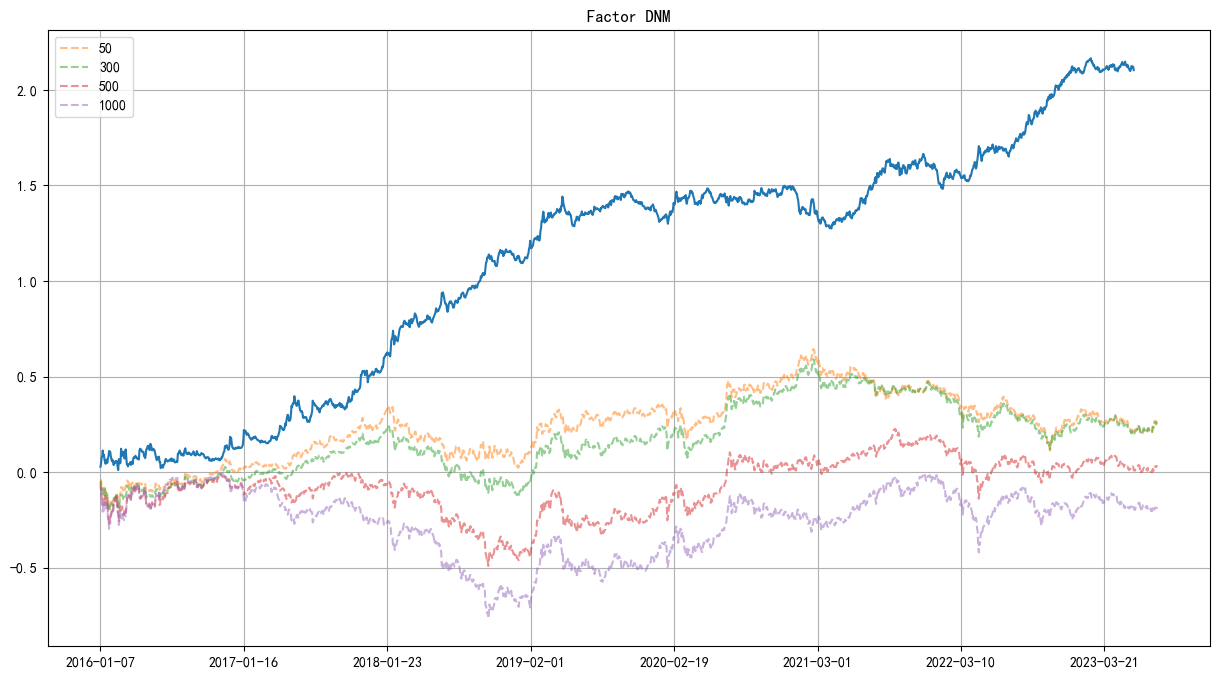

In [611]:
# 单因子强弱
DNM_select1, DNM_rets1 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # ((exR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2017-01-07':'2023-12-07'].shift(1,axis=1)).loc[['50',  '1000'],'2017-01-07':],
    exR.T.dropna().rolling(12,min_periods=2).apply(lambda x:(x.mean())/x.std()).T.shift(1,axis=1).loc[['50',  '1000'],'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-01-07':'2023-12-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [2409]:
TR300 = pd.concat([
    (xy.index_high.T['300'] - xy.index_low.T['300']).abs()/xy.cl.T['300'],
    (xy.index_high.T['300'] - xy.cl.T['300'].shift(1)).abs()/xy.cl.T['300'],
    (xy.cl.T['300'].shift(1) - xy.index_low.T['300']).abs()/xy.cl.T['300']
],axis=1).dropna().max(axis=1).rename('300')
TR50 = pd.concat([
    (xy.index_high.T['50'] - xy.index_low.T['50']).abs()/xy.cl.T['50'],
    (xy.index_high.T['50'] - xy.cl.T['50'].shift(1)).abs()/xy.cl.T['50'],
    (xy.cl.T['50'].shift(1) - xy.index_low.T['50']).abs()/xy.cl.T['50']
],axis=1).dropna().max(axis=1).rename('50')
TR500 = pd.concat([
    (xy.index_high.T['500'] - xy.index_low.T['500']).abs()/xy.cl.T['500'],
    (xy.index_high.T['500'] - xy.cl.T['500'].shift(1)).abs()/xy.cl.T['500'],
    (xy.cl.T['500'].shift(1) - xy.index_low.T['500']).abs()/xy.cl.T['500']
],axis=1).dropna().max(axis=1).rename('500')
TR1000 = pd.concat([
    (xy.index_high.T['1000'] - xy.index_low.T['1000']).abs()/xy.cl.T['1000'],
    (xy.index_high.T['1000'] - xy.cl.T['1000'].shift(1)).abs()/xy.cl.T['1000'],
    (xy.cl.T['1000'].shift(1) - xy.index_low.T['1000']).abs()/xy.cl.T['1000']
],axis=1).dropna().max(axis=1).rename('1000')
# ATR300 = TR.rolling(15).mean().dropna()

ATR = pd.concat([
    TR50,
    # TR300,
    # TR500,
    TR1000
],axis=1).rolling(60).mean().T

In [2411]:
adj_ATR = ATR.mean().dropna().map(lambda x: (x/0.01)**0.5 if x < 0.01 else ((x/0.02)**0.5 if x > 0.02 else 1))

In [2619]:
ATR.T.dropna()

50      1000
2005-04-07  0.017817  0.022462
2005-04-08  0.017937  0.022368
2005-04-11  0.017956  0.022418
2005-04-12  0.017948  0.022560
2005-04-13  0.018174  0.022729
...              ...       ...
2023-05-04  0.012376  0.011870
2023-05-05  0.012235  0.011994
2023-05-08  0.012362  0.012000
2023-05-09  0.012477  0.012096
2023-05-10  0.012451  0.011922

[4397 rows x 2 columns]

In [2629]:
high_increasing = (xy.index_high/xy.cl.shift(1,axis=1) - 1).loc[['50','1000']].T.dropna().mean(axis=1)
low_increasing = (xy.index_low/xy.cl.shift(1,axis=1) - 1).loc[['50','1000']].T.dropna().mean(axis=1)

In [2634]:
Y = pd.concat([
    (xy.Index_rets).loc[['50','1000']].T.dropna().mean(axis=1).rename('cl-cl'),
    high_increasing.rename('high_increasing'),
    low_increasing.rename('low_increasing')
],axis=1).dropna()

In [ ]:
def cal_break(x):
    if (x[-1]>0.01):
        if ((max(x[-6:-1])-min(x[-6:-1]))<0.01):
            (x.rolling(5).max()[-2] - x.rolling(5).min()[-2] >x.rolling(5).max()[-1] - x.rolling(5).min()[-1])) else np.nan

In [2623]:
(xy.Index_rets).loc[['50','1000']].T.dropna().mean(axis=1).rolling(11).apply(lambda x:).dropna()

Series([], dtype: float64)

In [2441]:
atr300 = pd.concat([
    (xy.Index_rets).loc[['50','1000'],adj_ATR.index].mean().rename('300'),
    adj_ATR.rename('ATR')
],axis=1).sort_index().dropna()

In [2586]:
atr300['shrd_down'] = -0.05 * atr300['ATR']
atr300['shrd_up'] = 0.005 * atr300['ATR']

In [2587]:
atr300['mdd20'] = atr300['300'].rolling(10).apply(lambda x:x[:-1].sum())#

In [ ]:
CN_Index_cumret = xy.Index_rets.loc[[ '300'],same_dates].T.loc['2010-01-04':]
CN_Index_cumret['Bondgap'] = Bondgap.loc[same_dates].diff().loc['2010-01-04':][::5]#rolling(120).apply(lambda x:x.rank()[-1]/120).loc['2017-01-04':]
CN_Index_cumret['Bond10'] = BondCN10yield.loc[same_dates].diff().loc['2010-01-04':][::5]
CN_Index_cumret['Bond1'] = BondCN1yield.loc[same_dates].diff().loc['2010-01-04':][::5]

In [ ]:
CN_Index_cumret

300  Bondgap  Bond10   Bond1
2010-01-04 -0.011314   0.0181  0.0314  0.0133
2010-01-11 -0.010762   0.0271  0.0373  0.0102
2010-01-18 -0.005609   0.0206  0.0336  0.0130
2010-01-25 -0.016952   0.0065  0.0195  0.0130
2010-02-01 -0.033009  -0.0272 -0.0135  0.0137
...              ...      ...     ...     ...
2023-04-27  1.089750  -0.2693  0.1832  0.4525
2023-05-09  1.081188  -0.2687  0.1808  0.4495
2023-05-16  1.076016  -0.2762  0.1837  0.4599
2023-05-23  1.061873  -0.2465  0.1664  0.4129
2023-05-30  1.062867  -0.2385  0.1609  0.3994

[652 rows x 4 columns]

In [ ]:
CN_Index_cumret['Bond10'].diff().shift(1).corr(CN_Index_cumret['300'].diff())

0.017523012154161653

<Axes: >

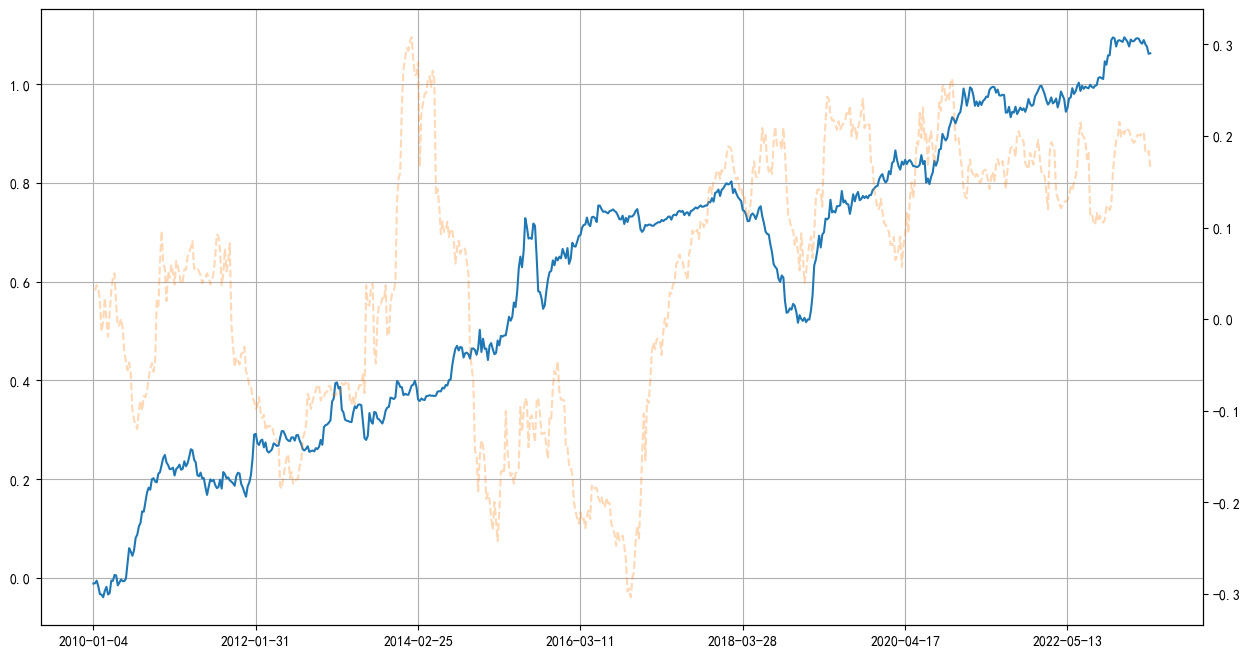

In [2820]:
# BondCN10yield.loc[same_dates].plot()
CN_Index_cumret['300'].plot(figsize=(15,8),grid=True)
# CN_Index_cumret['Bondgap'].plot(figsize=(15,8),secondary_y=True)
CN_Index_cumret['Bond10'].shift(1).plot(figsize=(15,8),secondary_y=True,style='--',alpha=0.3)
# CN_Index_cumret['Bond1'].plot(figsize=(15,8),secondary_y=True,style='--',alpha=0.3)

<Axes: >

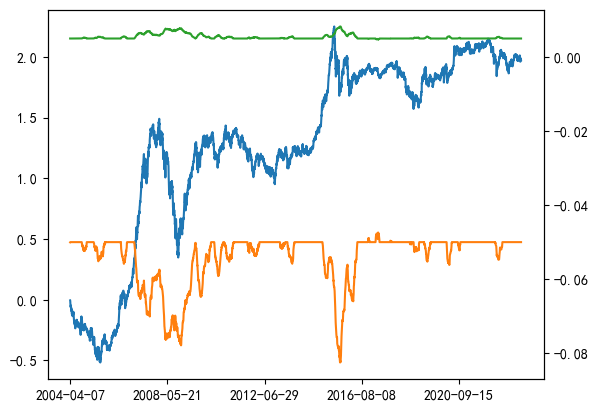

In [2589]:
atr300['300'].cumsum().plot()
atr300['shrd_down'].plot(secondary_y=True)
atr300['shrd_up'].plot(secondary_y=True)

In [2590]:
rebound_dates = atr300.dropna()[(atr300.dropna()['300'] >= atr300.dropna()['shrd_up']) & (atr300.dropna()['mdd20'] < atr300.dropna()['shrd_down'])].index

In [2591]:
len(rebound_dates)

197

In [2630]:
xxx50 = pd.Series((DNexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1).loc[:,(DNexR).T[(DNexR).T.index.isin(rebound_dates[:])].dropna().cumsum().index].loc['50'],index = DNexR.columns).rename('50')
xxx1000 = pd.Series((DNexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1).loc[:,(DNexR).T[(DNexR).T.index.isin(rebound_dates[:])].dropna().cumsum().index].loc['1000'],index = DNexR.columns).rename('1000')

<Axes: >

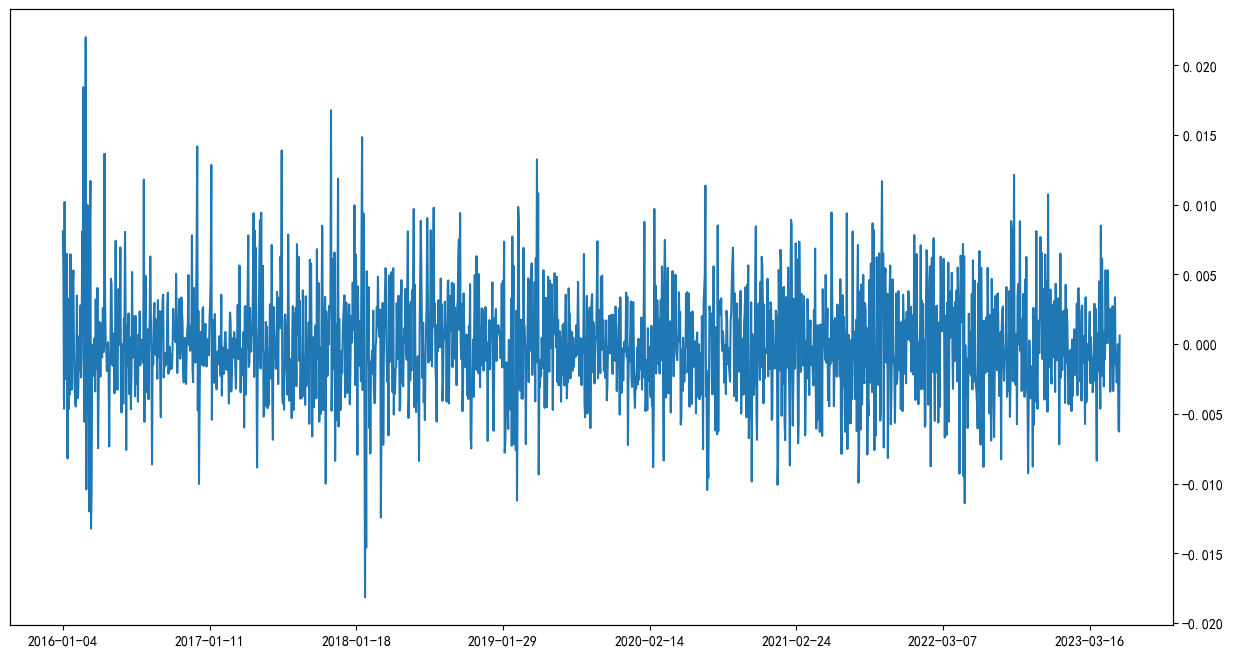

In [2674]:
# (xy.Index_rets.loc['50','2016-01-04':].rename('50') - xy.Index_rets.loc['300','2016-01-04':].rename('300')).dropna().rolling(240).apply(lambda x: (x[-1] - x.mean())/x.std())[:].dropna().plot(figsize=(15,8))
(xy.Index_rets.loc['50','2016-01-04':].rename('50') - xy.Index_rets.loc['300','2016-01-04':].rename('300')).dropna()[:].dropna().plot(figsize=(15,8),secondary_y=True)

In [307]:
TOV120 = (xy.index_tov.T.loc[:,:].rolling(60).mean()).loc['2006-04-30':].dropna()
STD120 = (xy.cl.T.loc[:,:].pct_change().rolling(60).std()).loc['2006-04-30':,['50','300','500','1000']].dropna()

In [308]:
SP = TOV120/STD120

In [309]:
tov_down_diff = TOV120.rolling(5).mean() - TOV120.rolling(10).mean()
tov_down_diff2 = tov_down_diff.rolling(1).mean() - tov_down_diff.rolling(5).mean()

In [368]:
std_down_diff = STD120.rolling(5).mean() - STD120.rolling(10).mean()
std_down_diff2 = std_down_diff.rolling(1).mean() - std_down_diff.rolling(5).mean()

In [311]:
SP_diff = SP.rolling(5).mean() - SP.rolling(10).mean()
SP_diff2 = SP_diff.rolling(1).mean() - SP_diff.rolling(5).mean()

2138.0
yoy: 0.057109681173020926 
 mdd: -0.3775820666870072 
 sharpe: 0.2880827022147748 
 rankIC: 0.008305166586190248 
 rankIR: 0.010825545183228272 
 win%: 0.5026557218734911 
 gain_loss%: -1.042689565283234


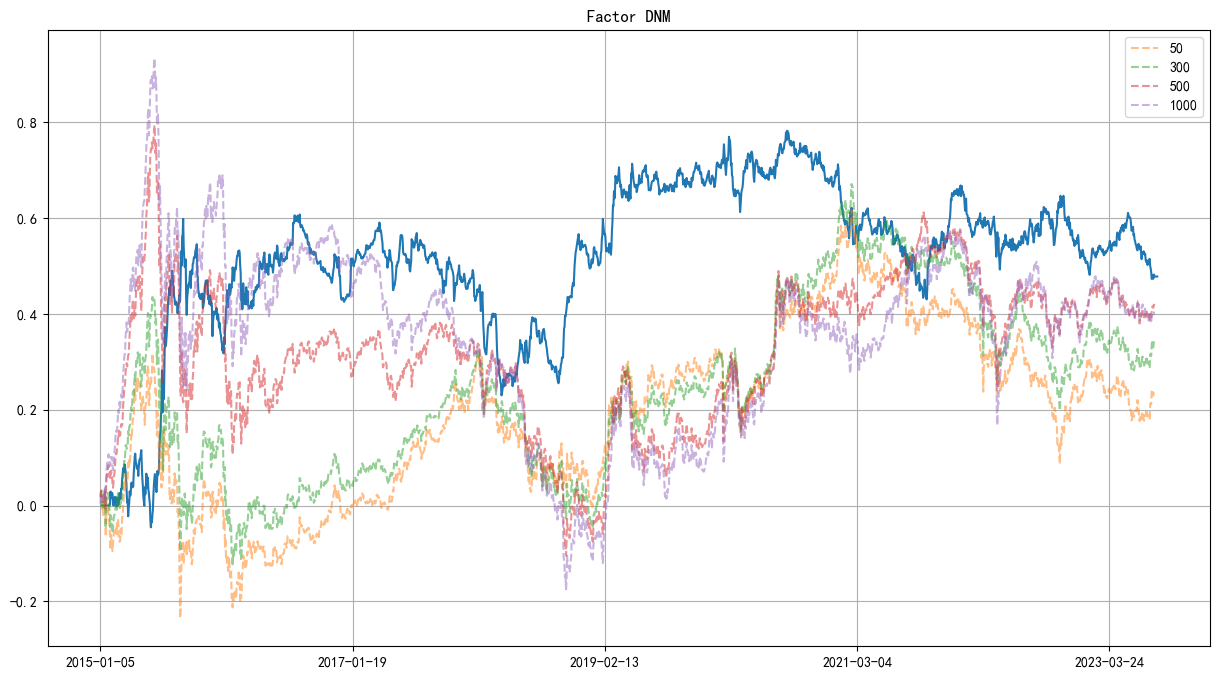

In [314]:
# new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

# new_high_count_cp = new_high_count.copy()
# new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
# new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
# new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    SP_diff2.T.loc[['50','300', '500', '1000'],'2015-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1),
    
    #     pd.concat([
    #     xxx50,
    #     xxx1000,
    # ],axis=1).shift(0).T.loc[['50','1000'],'2004-01-04':],
    
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2015-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
# new_high_count_cp.rolling(10).sum()['2006-01-04':'2012-01-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
# (((xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.diff().T).sum() - ATR.mean()['2006-01-04':'2012-01-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

2522.0
yoy: 0.9143790417720457 
 mdd: -0.1848193414348942 
 sharpe: 4.001435389019025 
 rankIC: 0.18286879673691367 
 rankIR: 0.1859421092205074 
 win%: 0.5914343983684568 
 gain_loss%: -1.3671628689721322


<Axes: >

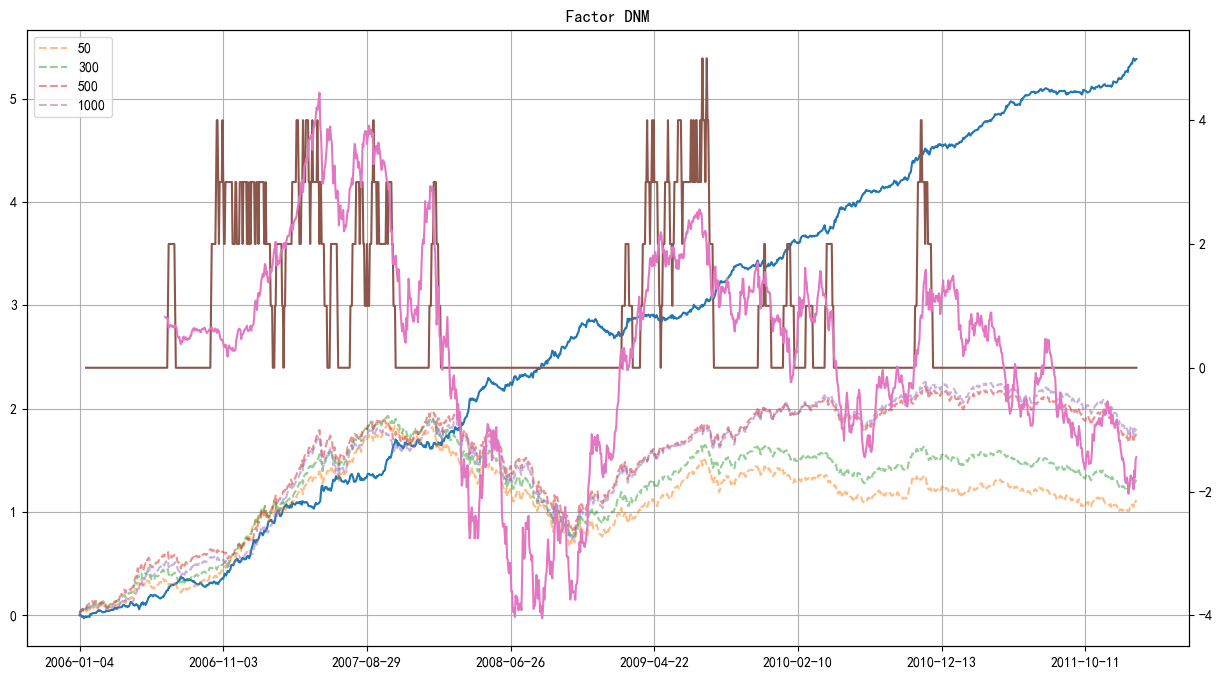

In [2560]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2006-01-04':'2012-01-23'].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2006-01-04':'2012-01-23'],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2006-01-04':'2012-01-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.diff().T).sum() - ATR.mean()['2006-01-04':'2012-01-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

3094.0
yoy: 0.47455653599883985 
 mdd: -0.32558741054628615 
 sharpe: 1.8758445055622324 
 rankIC: 0.10324483775811209 
 rankIR: 0.10376892153880402 
 win%: 0.5512971698113207 
 gain_loss%: -1.144176559933327


<Axes: >

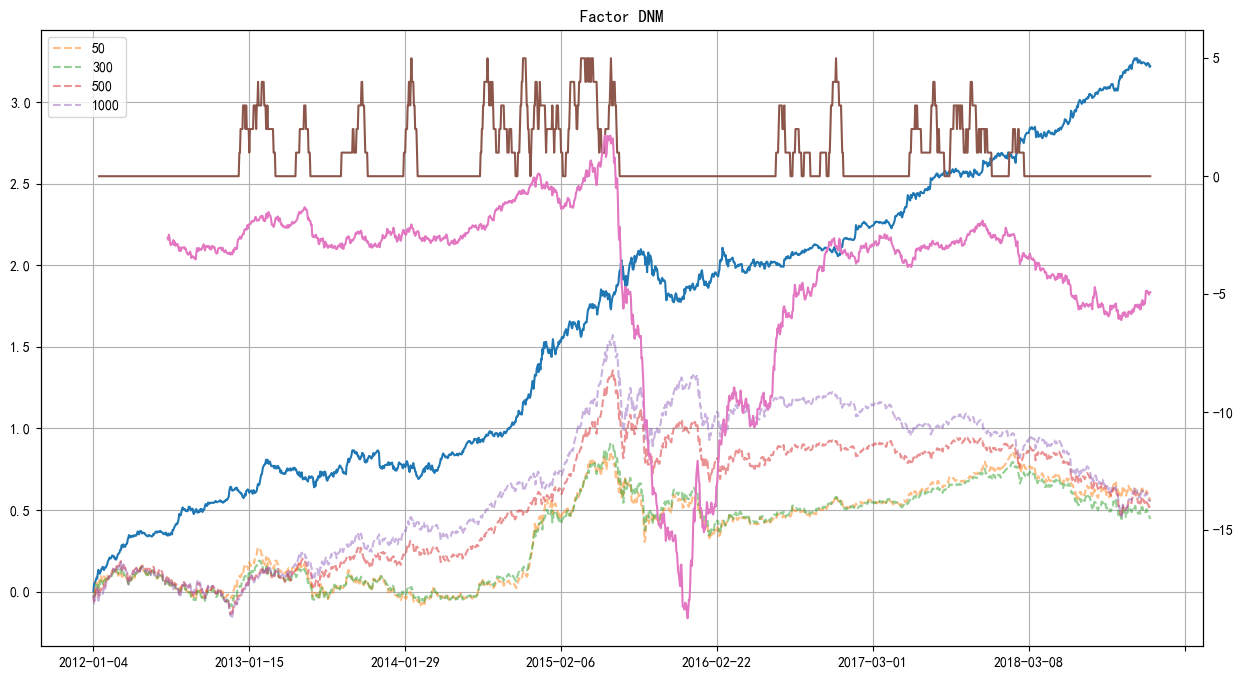

In [1838]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2012-01-04':'2018-12-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2012-01-04':'2018-12-23'].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2012-01-04':'2018-12-23'],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2012-01-04':'2018-12-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2012-01-04':'2018-12-23'].T.diff().T).sum() - ATR.mean()['2012-01-04':'2018-12-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

2166.0
yoy: -0.0046961903383438 
 mdd: -0.38461039677859443 
 sharpe: -0.024168383002112385 
 rankIC: -0.016052880075542966 
 rankIR: -0.016047366817944296 
 win%: 0.4919735599622285 
 gain_loss%: -1.0286024449376499


KeyError: '2018-12-23'

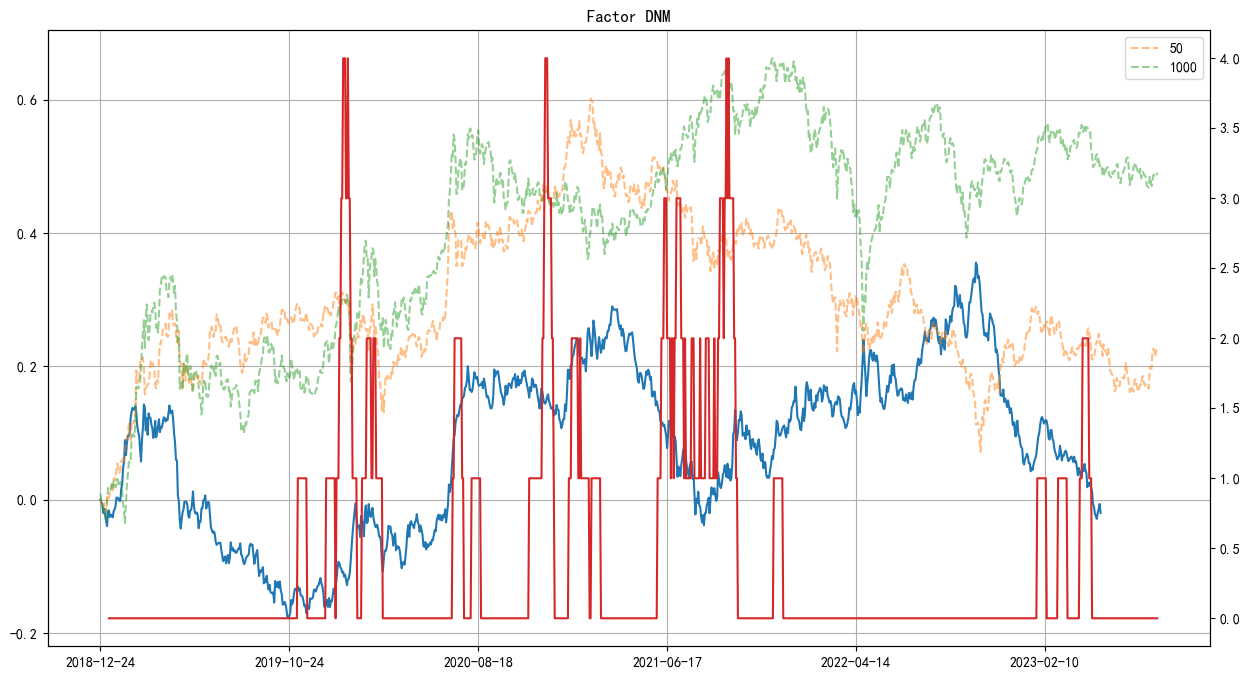

In [123]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2018-12-23':].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0


# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:(x[-1] - x.mean())/x.std()).T.loc[['50','1000'],'2018-12-23':].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50','1000'],'2018-12-23':],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2018-12-23':].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2018-12-23':].T.diff().T).sum() - ATR.mean()['2018-12-23':])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

658.0
yoy: -0.0026057226184142052 
 mdd: -0.8117769368687741 
 sharpe: -0.01303696541280934 
 rankIC: -0.023569023569023562 
 rankIR: -0.023568956732995354 
 win%: 0.4879416713404375 
 gain_loss%: -1.0459746114131545


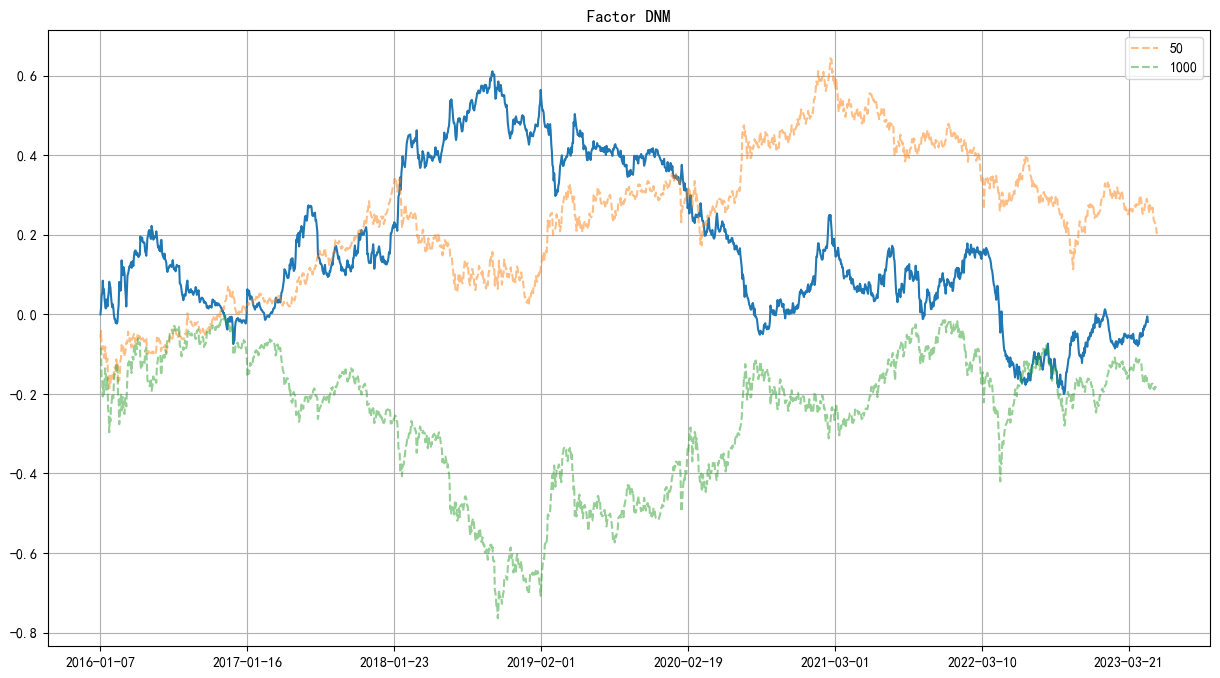

In [1736]:
# 单因子强弱
DNM_select3, DNM_rets3 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (ONexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '1000'],'2016-01-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

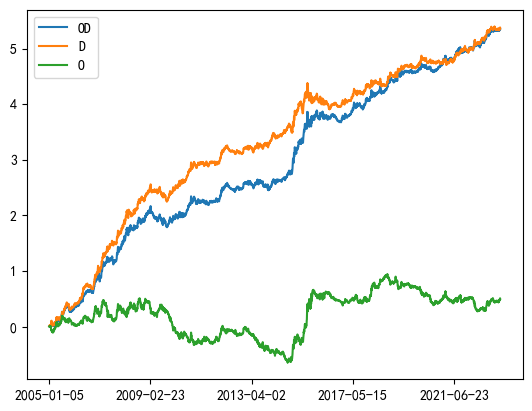

In [1527]:
pd.concat([
    DNM_rets1.rename('OD'),
    DNM_rets2.rename('D'),
    DNM_rets3.rename('O'),
],axis=1).dropna().cumsum().plot()

### Sharpe

In [454]:
((xy.op/xy.cl.shift(axis=1)-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':]

2006-05-08    0.002025
2006-05-09    0.002051
2006-05-10    0.002072
2006-05-11    0.002073
2006-05-12    0.001991
                ...   
2023-05-04    0.004790
2023-05-05    0.004772
2023-05-08    0.004626
2023-05-09    0.004625
2023-05-10    0.004599
Length: 4139, dtype: float64

In [469]:
std_down_diff = ((xy.cl/xy.op-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':].dropna().rolling(5).mean() - ((xy.cl/xy.op-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':].dropna().rolling(20).mean()

In [431]:
R = DNM_rets11[(xy.index_tov.loc[:,:].mean().rolling(250).mean().loc['2006-04-30':].dropna().shift(1)>=0.55)]

<Axes: >

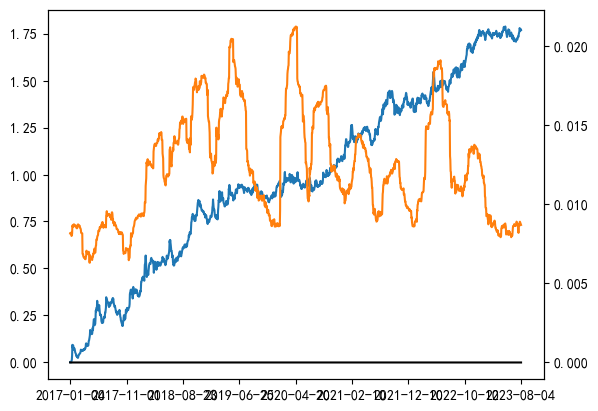

In [450]:
# DNM_rets11[(std_down_diff.loc[DNM_rets11.index].rolling(1).sum().shift(1) > 0.00)].cumsum().plot()
# DNM_rets11[(xy.index_tov.loc[:,:].mean().rolling(250).mean().loc['2006-04-30':].dropna().shift(1)>=0.55)].cumsum().plot()
DNM_rets11.cumsum().plot()
STD120.mean(axis=1).loc[DNM_rets11.index].plot(secondary_y=True)
pd.Series(0,DNM_rets11.index).plot(secondary_y=True,color='black')

In [441]:
DNM_rets11

2017-01-04    0.000000
2017-01-05   -0.000112
2017-01-06   -0.001100
2017-01-09   -0.001033
2017-01-10    0.002643
                ...   
2023-07-31   -0.005412
2023-08-01   -0.001523
2023-08-02   -0.007777
2023-08-03    0.008794
2023-08-04   -0.004109
Length: 1601, dtype: float64

<Axes: >

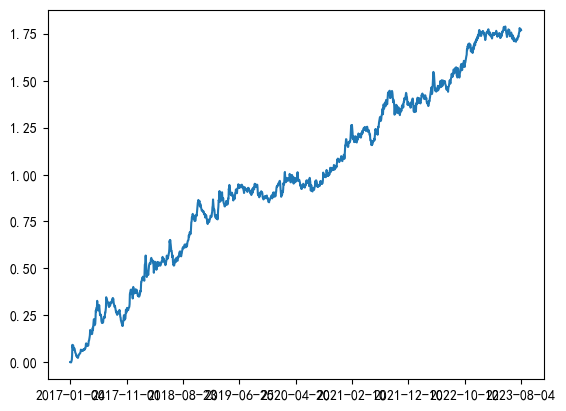

In [453]:
DNM_rets11.cumsum().plot()

<Axes: >

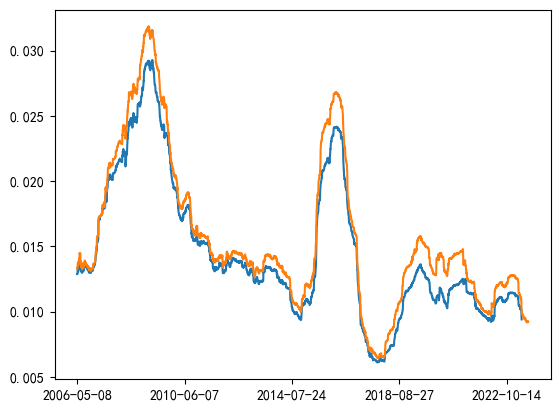

In [470]:
((xy.cl/xy.op-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':].plot()
((xy.Index_rets).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':].plot()

In [479]:
tov_down_diff

50       300       500      1000
2015-01-12       NaN       NaN       NaN       NaN
2015-01-13       NaN       NaN       NaN       NaN
2015-01-14       NaN       NaN       NaN       NaN
2015-01-15       NaN       NaN       NaN       NaN
2015-01-16       NaN       NaN       NaN       NaN
...              ...       ...       ...       ...
2023-08-08 -0.005263 -0.011131 -0.006780 -0.009727
2023-08-09 -0.005712 -0.011407 -0.007363 -0.008635
2023-08-10 -0.005418 -0.010432 -0.006372 -0.006289
2023-08-11 -0.004701 -0.009067 -0.006012 -0.004892
2023-08-14 -0.003977 -0.007729 -0.006128 -0.004409

[2091 rows x 4 columns]

<Axes: >

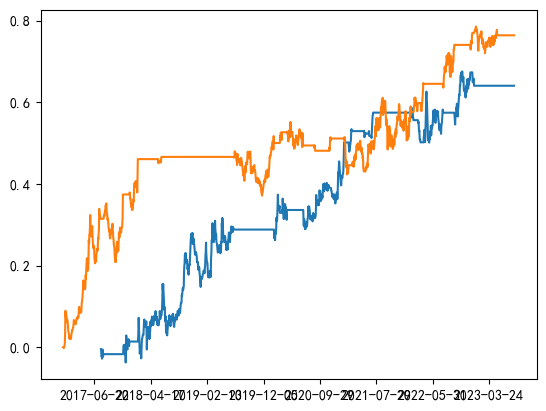

In [485]:
pd.Series(DNM_rets11.loc[DNM_rets11.dropna().index&std_down_diff.index][(std_down_diff.shift(1)>=0.00)&(tov_down_diff2.mean(axis=1).shift(1)!=0)],index=DNM_rets11.index).cumsum().ffill().plot()
pd.Series(DNM_rets11.loc[DNM_rets11.dropna().index&std_down_diff.index][(std_down_diff.shift(1)<=0.00)&(tov_down_diff2.mean(axis=1).shift(1)!=0)],index=DNM_rets11.index).cumsum().ffill().plot()

<Axes: >

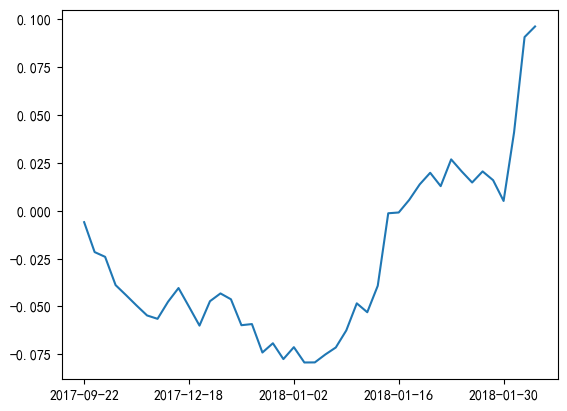

In [471]:
DNM_rets11.loc[DNM_rets11.dropna().index&std_down_diff.index][(((xy.op/xy.cl.shift(axis=1)-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean().rolling(250).std().loc['2006-04-30':].shift(1)<=0.002)].cumsum().plot()

In [429]:
((xy.op/xy.cl.shift(axis=1)-1).loc[['50', '300', '500', '1000']]).T.dropna().T.mean()

2005-01-05   -0.000840
2005-01-06    0.000667
2005-01-07   -0.000259
2005-01-10   -0.000129
2005-01-11    0.000211
                ...   
2023-05-04   -0.003837
2023-05-05   -0.000068
2023-05-08    0.001931
2023-05-09   -0.000020
2023-05-10   -0.002143
Length: 4456, dtype: float64

<Axes: >

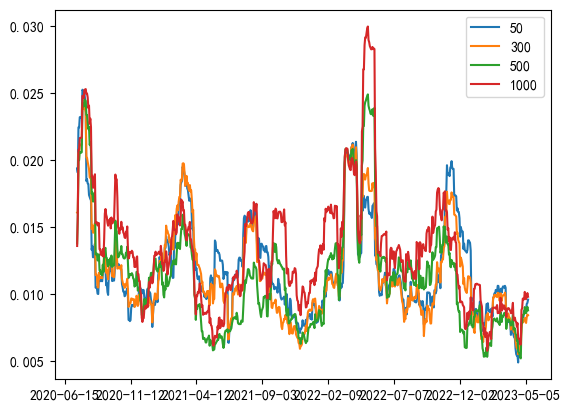

In [422]:
(((xy.op/xy.cl.shift(axis=1)).loc[['50', '300', '500', '1000']]).T.dropna() * ((xy.cl/xy.op).loc[['50', '300', '500', '1000']]) .T.dropna() - 1).dropna().loc['2020-06-14':'2023-06-14'].rolling(20).std().plot()

<Axes: >

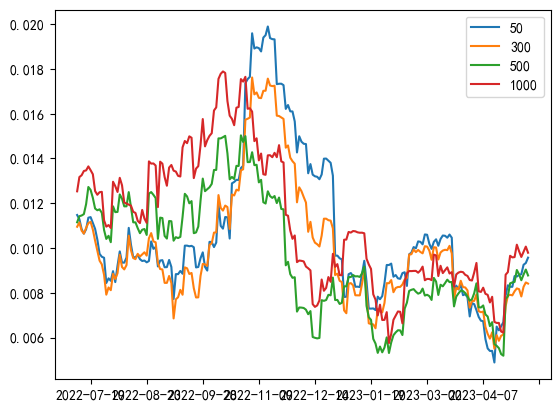

In [419]:
(((xy.op/xy.cl.shift(axis=1)).loc[['50', '300', '500', '1000']]) .T.dropna() * ((xy.cl/xy.op).loc[['50', '300', '500', '1000']]) .T.dropna() - 1).dropna().loc['2022-06-14':].rolling(20).std().plot()

<Axes: >

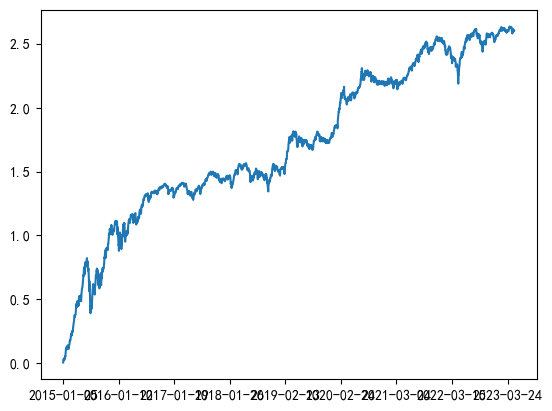

In [496]:
((xy.cl/xy.op)-1).loc['1000','2015-01-04':].T.dropna().cumsum().plot()

622.0
yoy: 0.2192780771425042 
 mdd: -0.14723018788332332 
 sharpe: 1.202799359387658 
 rankIC: 0.05584415584415584 
 rankIR: 0.05591327448248356 
 win%: 0.5279220779220779 
 gain_loss%: -1.0961340953157213


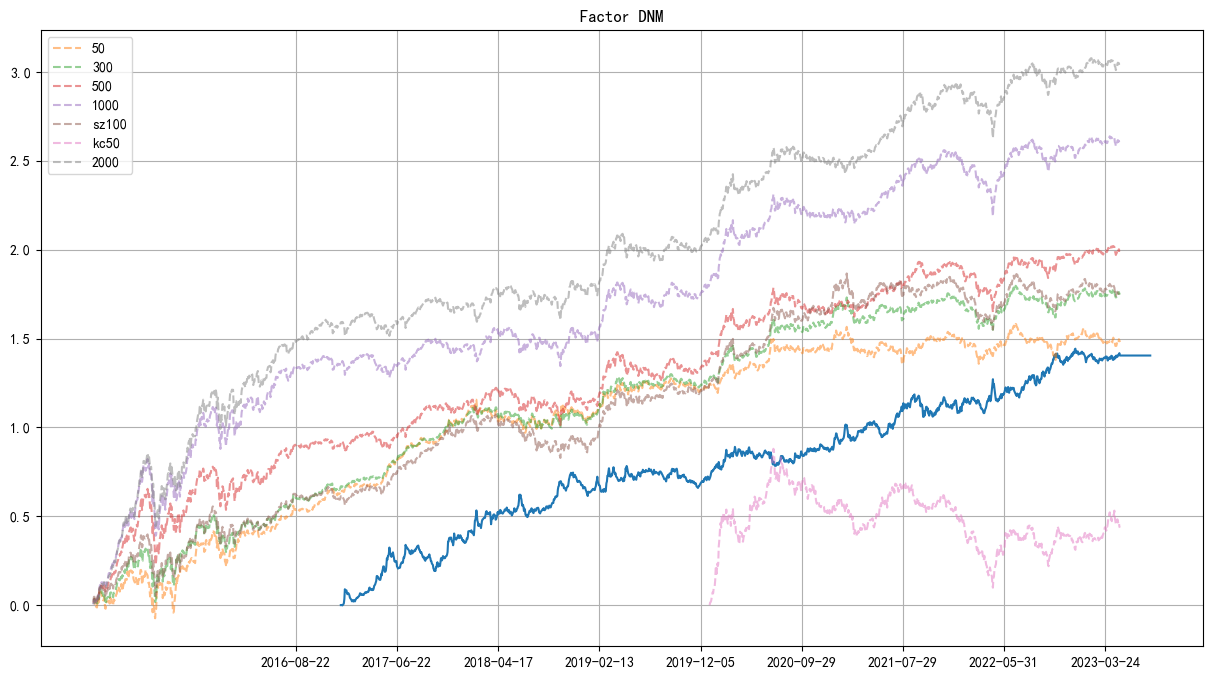

In [482]:
# 单因子强弱
DNM_select11, DNM_rets11 = xy.single_Factor_backtest(
    (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-04':].shift(1,axis=1),
    # xy.index_tov.pct_change(axis=1).shift(1,axis=1).loc[['50', '1000'],:],
    # xy.Index_rets.loc[:,:].T.rolling(13).apply(lambda x:x.mean()/x.std()).T.shift(1,axis=1).loc[['50', '300', '500', '1000'],:],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    ((xy.cl/xy.op)-1).loc[:,'2015-01-04':],
    # xy.Index_rets.loc[['50', '1000'],'2017-01-04':],
    _side=1,
    fee=0.000,
    name='DNM'
)
# xy.cl.loc['300',:].pct_change().rolling(250).std().loc['2006-04-29':].dropna().plot(secondary_y=True)
# TOV120['1000'].rolling(20).mean().loc['2012-01-04':].dropna().plot(secondary_y=True)
# tov_down_diff2['1000'].rolling(20).mean().loc['2016-01-30':].dropna().plot(secondary_y=True)

In [350]:
xy.bonus_open_cl_rets

2002-12-31  2003-01-02  2003-01-03  2003-01-06  2003-01-07  2003-01-08  \
50            NaN         NaN         NaN         NaN         NaN         NaN   
300           NaN         NaN         NaN         NaN         NaN         NaN   
500           NaN         NaN         NaN         NaN         NaN         NaN   
1000          NaN         NaN         NaN         NaN         NaN         NaN   
sz100         NaN         NaN         NaN         NaN         NaN         NaN   
kc50          NaN         NaN         NaN         NaN         NaN         NaN   
2000          NaN         NaN         NaN         NaN         NaN         NaN   

       2003-01-09  2003-01-10  2003-01-13  2003-01-14  ...  2023-07-24  \
50            NaN         NaN         NaN         NaN  ...         NaN   
300           NaN         NaN         NaN         NaN  ...         NaN   
500           NaN         NaN         NaN         NaN  ...         NaN   
1000          NaN         NaN         NaN         NaN  ...         NaN   
sz100         NaN         NaN         NaN         NaN  ...         NaN   
kc50          NaN         NaN         NaN         NaN  ...         NaN   
2000          NaN         NaN         NaN         NaN  ...         NaN   

       2023-07-25  2023-07-26  2023-07-27  2023-07-28  2023-07-31  2023-08-01  \
50            NaN         NaN         NaN         NaN         NaN         NaN   
300           NaN         NaN         NaN         NaN         NaN         NaN   
500           NaN         NaN         NaN         NaN         NaN         NaN   
1000          NaN         NaN         NaN         NaN         NaN         NaN   
sz100         NaN         NaN         NaN         NaN         NaN         NaN   
kc50          NaN         NaN         NaN         NaN         NaN         NaN   
2000          NaN         NaN         NaN         NaN         NaN         NaN   

       2023-08-02  2023-08-03  2023-08-04  
50            NaN         NaN         NaN  
300           NaN         NaN         NaN  
500           NaN         NaN         NaN  
1000          NaN         NaN         NaN  
sz100         NaN         NaN         NaN  
kc50          NaN         NaN         NaN  
2000          NaN         NaN         NaN  

[7 rows x 5002 columns]

1650.0
yoy: -0.003005842263438244 
 mdd: -0.31360304591995536 
 sharpe: -0.04866077094641566 
 rankIC: 0.009857072449482503 
 rankIR: 0.014226560836497716 
 win%: 0.50418925579103 
 gain_loss%: -0.9721920680240992


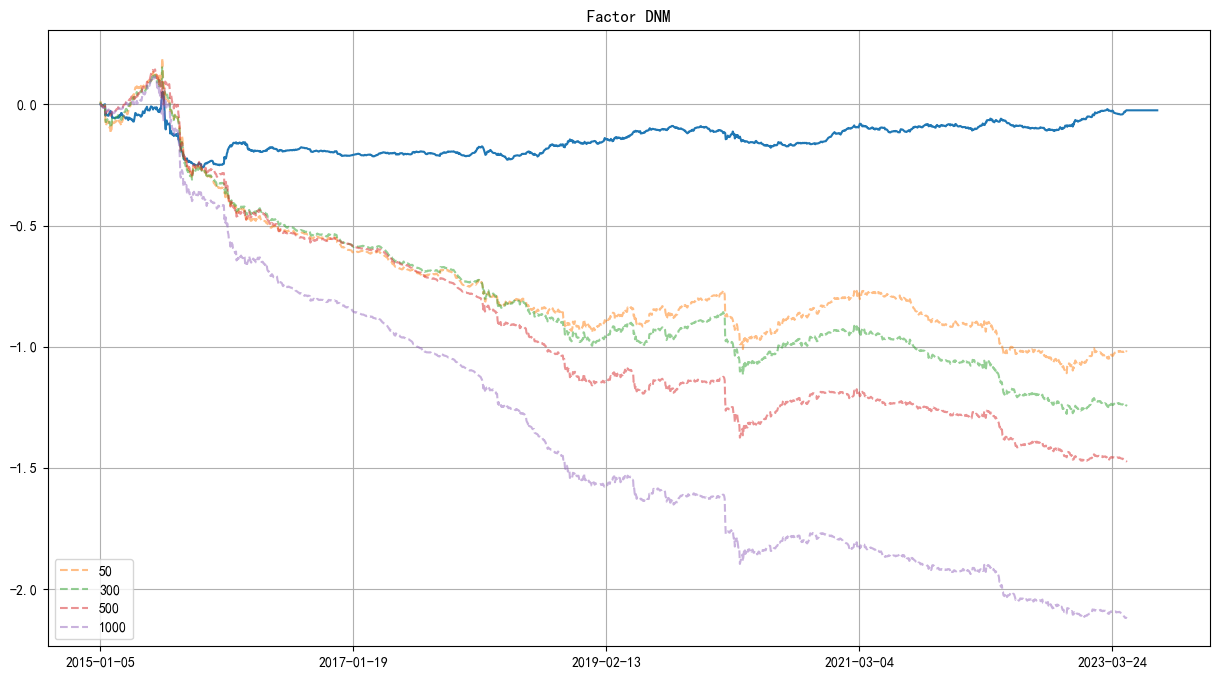

In [365]:
# 单因子强弱
DNM_select11, DNM_rets11 = xy.single_Factor_backtest(
    (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50','300','500', '1000'],'2015-01-04':].shift(1,axis=1),
    # xy.index_tov.pct_change(axis=1).shift(1,axis=1).loc[['50', '1000'],:],
    # xy.Index_rets.loc[:,:].T.rolling(13).apply(lambda x:x.mean()/x.std()).T.shift(1,axis=1).loc[['50', '300', '500', '1000'],:],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50','300','500', '1000'],'2015-01-04':],
    _side=1,
    fee=0.000,
    name='DNM'
)
# xy.cl.loc['300',:].pct_change().rolling(250).std().loc['2006-04-29':].dropna().plot(secondary_y=True)
# TOV120['1000'].rolling(20).mean().loc['2012-01-04':].dropna().plot(secondary_y=True)
# tov_down_diff2['1000'].rolling(20).mean().loc['2016-01-30':].dropna().plot(secondary_y=True)

1334.0
yoy: 0.08744441356552411 
 mdd: -0.9070740111423712 
 sharpe: 0.38198995910159 
 rankIC: 0.0493046776232617 
 rankIR: 0.04935691412671195 
 win%: 0.5091656131479141 
 gain_loss%: -1.0304931271088589


<Axes: >

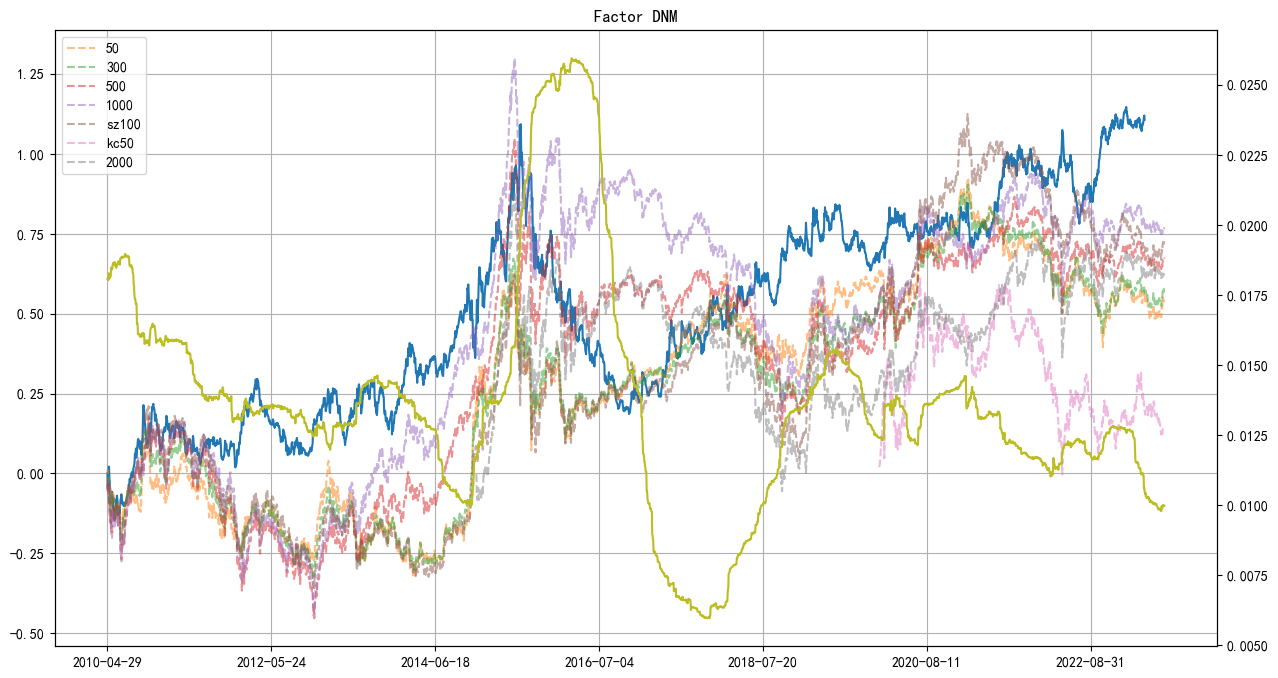

In [208]:
# 单因子强弱
DNM_select22, DNM_rets22 = xy.single_Factor_backtest(
    (DN).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2010-04-29':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,'2010-04-29':],
    _side=1,
    fee=0.001,
    name='DNM'
)
xy.cl.loc['300',:].pct_change().rolling(250).std().loc['2010-04-29':].dropna().plot(secondary_y=True)

2684.0
yoy: 0.08527230942210702 
 mdd: -1.6547350780030547 
 sharpe: 0.42522900152021215 
 rankIC: -0.020383789380755198 
 rankIR: -0.027414341365673233 
 win%: 0.4872082585278277 
 gain_loss%: -1.1313174190920015


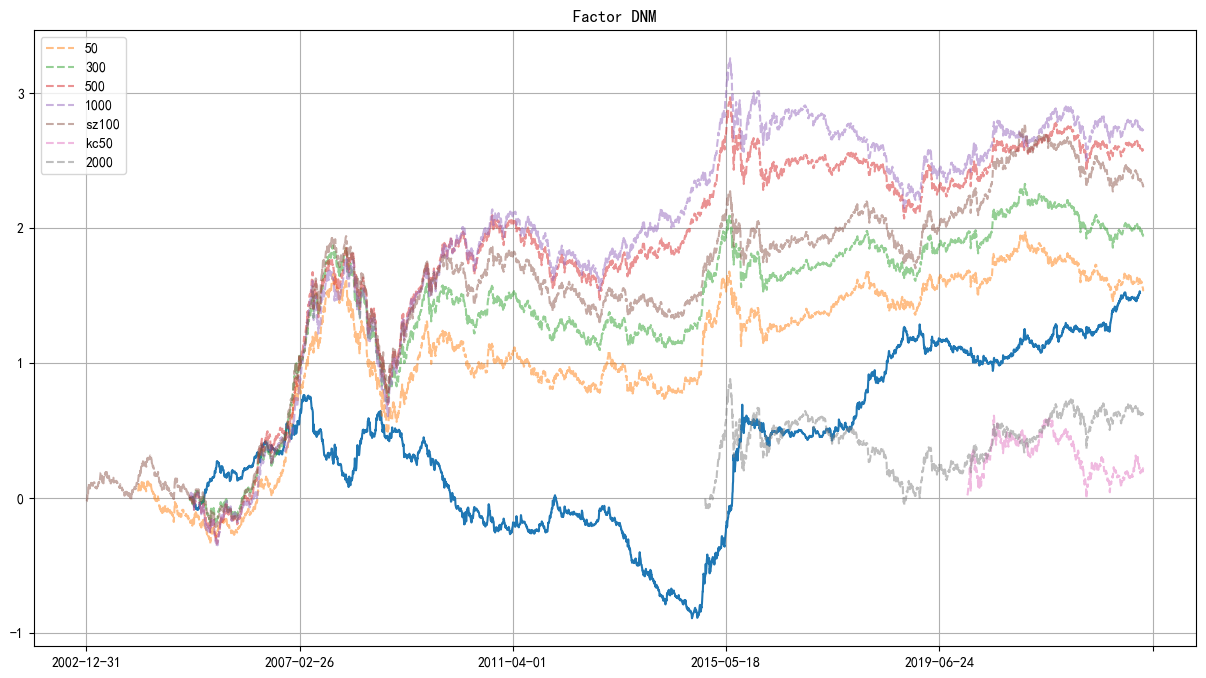

In [1530]:
# 单因子强弱
DNM_select33, DNM_rets33 = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()/x.std()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

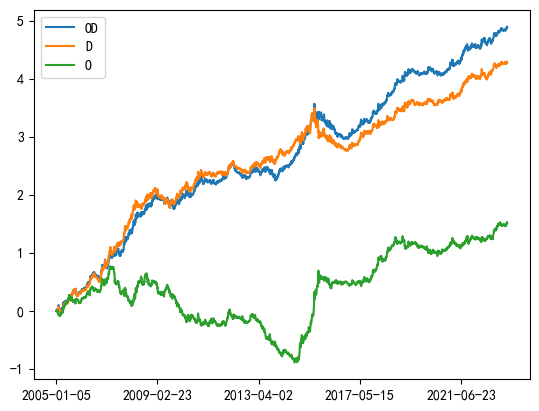

In [1480]:
pd.concat([
    DNM_rets11.rename('OD'),
    DNM_rets22.rename('D'),
    DNM_rets33.rename('O'),
],axis=1).dropna().cumsum().plot()

### 30日归一化动量

6486.0
yoy: 0.3779841740261326 
 mdd: -0.40306633975071904 
 sharpe: 1.4915346895330228 
 rankIC: 0.08838500694123091 
 rankIR: 0.08872200492111236 
 win%: 0.5347845601436265 
 gain_loss%: -1.1283007699367118


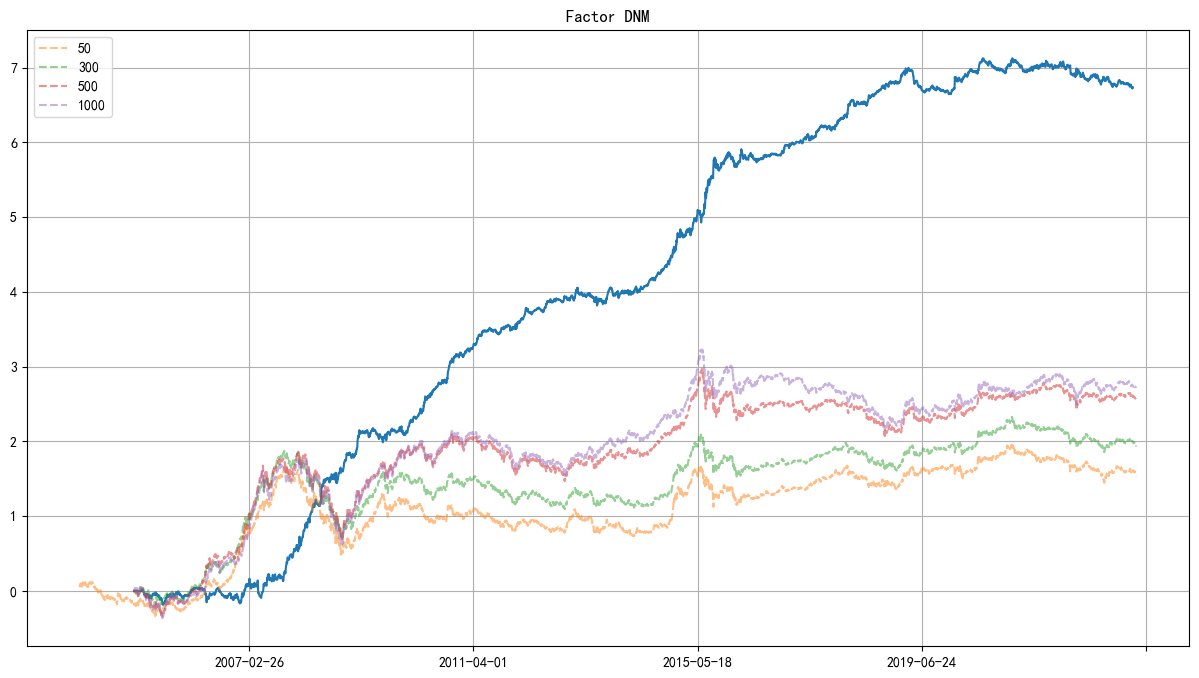

In [1468]:
# 单因子强弱
DNM_select111, DNM_rets111 = xy.single_Factor_backtest(
    ((DN+1)*(ON+1)-1).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

10464.0
yoy: 0.2937084091575024 
 mdd: -0.6146353649811882 
 sharpe: 0.9256209755130389 
 rankIC: 0.0794607404908919 
 rankIR: 0.10444825871585542 
 win%: 0.5378056989006058 
 gain_loss%: -1.0511633629134833


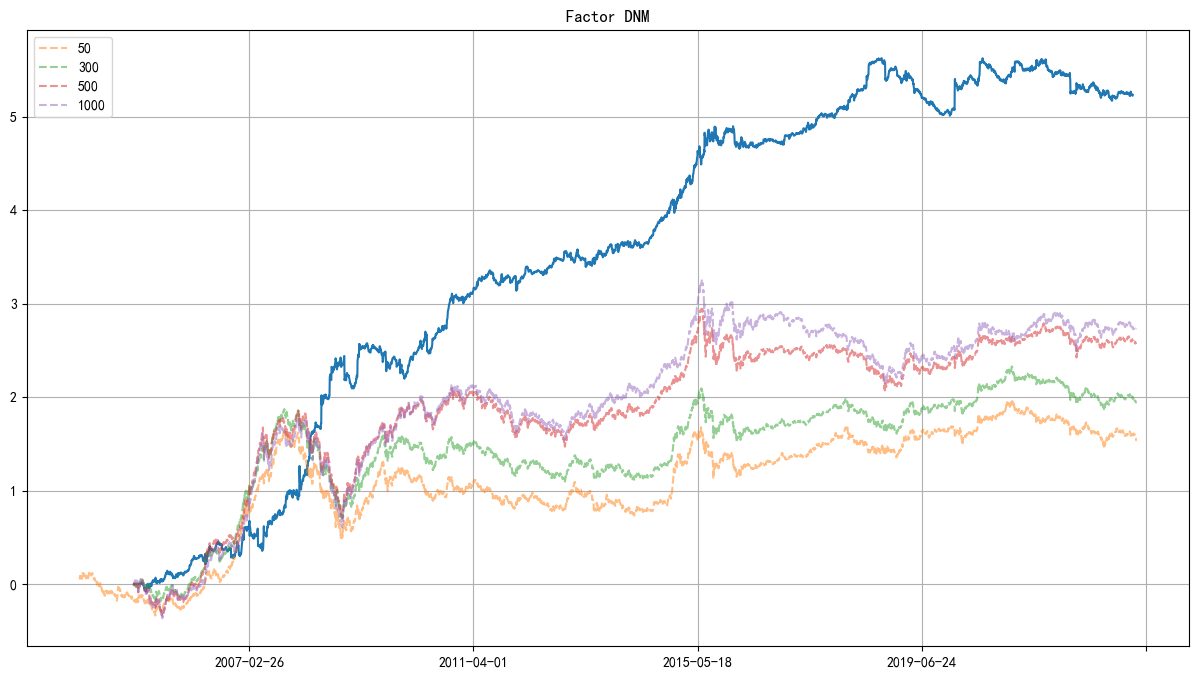

In [1472]:
# 单因子强弱
DNM_select222, DNM_rets222 = xy.single_Factor_backtest(
    ((DN)).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

9728.0
yoy: -0.03582998376736685 
 mdd: -1.833115945139594 
 sharpe: -0.11073027840796502 
 rankIC: 0.013605145193451159 
 rankIR: 0.0185143457607147 
 win%: 0.4955116696588869 
 gain_loss%: -0.9781491695675292


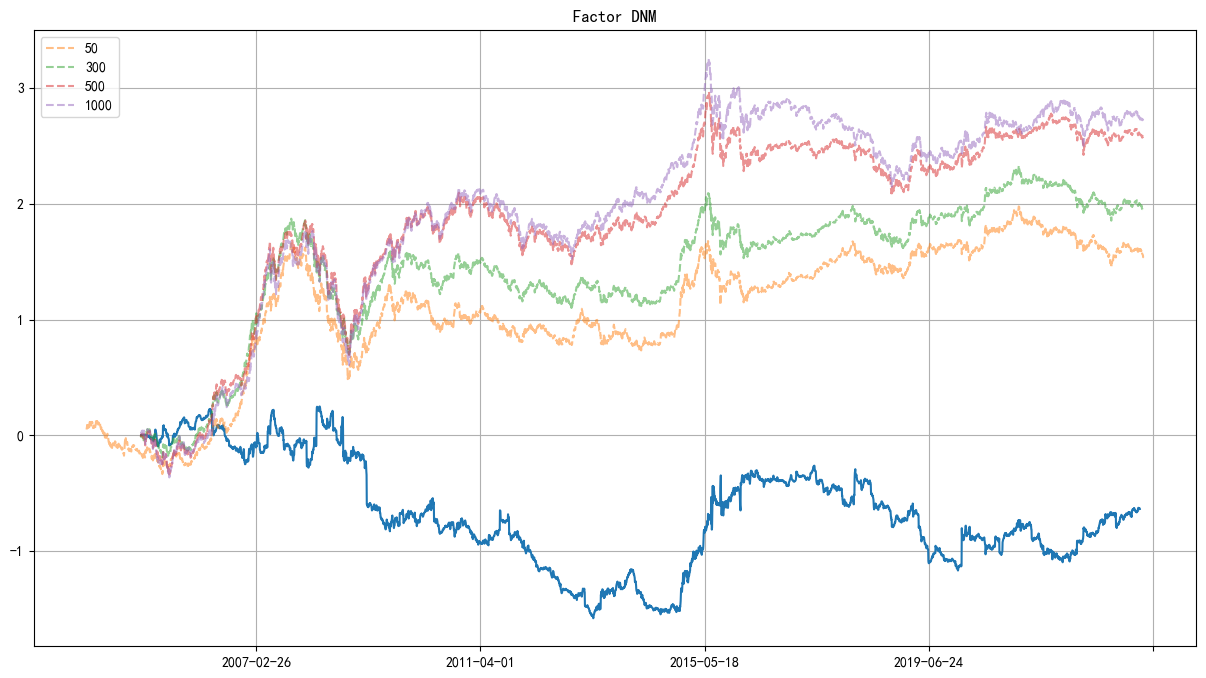

In [1473]:
# 单因子强弱
DNM_select333, DNM_rets333 = xy.single_Factor_backtest(
    ((ON)).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

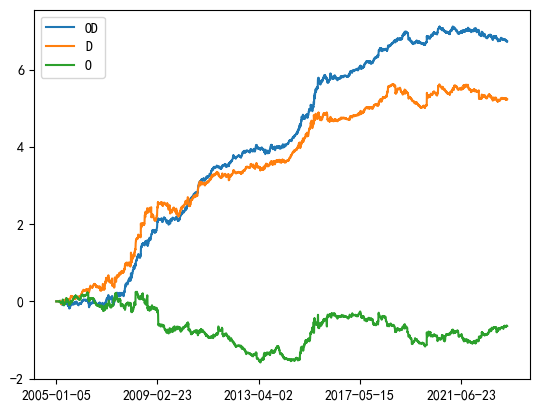

In [1474]:
pd.concat([
    DNM_rets111.rename('OD'),
    DNM_rets222.rename('D'),
    DNM_rets333.rename('O'),
],axis=1).dropna().cumsum().plot()

### ExR Singular

6770.0
yoy: 0.34614909216200374 
 mdd: -0.3861206934866148 
 sharpe: 1.5835660588288774 
 rankIC: 0.09095002251238178 
 rankIR: 0.09131825677042912 
 win%: 0.49213392496974584 
 gain_loss%: -1.112686660570028


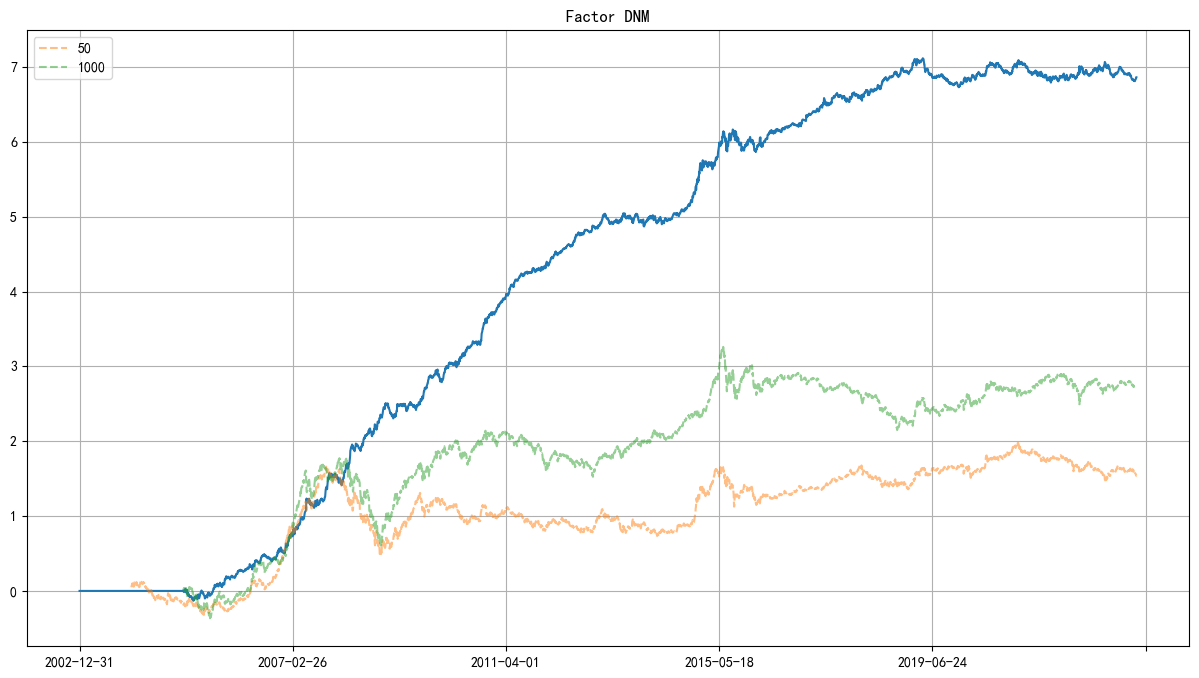

In [1520]:
# 单因子强弱
DNM_select1111, DNM_rets1111 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (exR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

11450.0
yoy: 0.4021439034309918 
 mdd: -0.31856285419787866 
 sharpe: 2.015215093404824 
 rankIC: 0.08776106654434424 
 rankIR: 0.12043030721607953 
 win%: 0.5508189365043752 
 gain_loss%: -1.1663774862884897


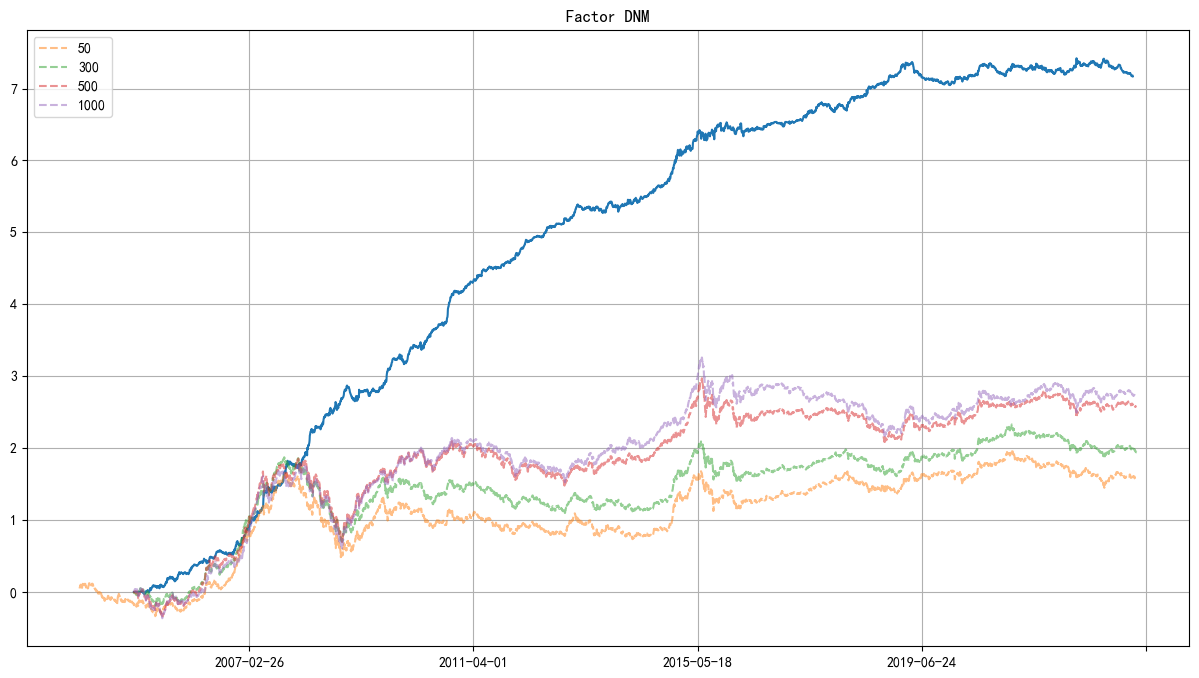

In [1517]:
# 单因子强弱
DNM_select2222, DNM_rets2222 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500','1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50' , '300', '500', '1000'],:],
    _side=1,
    fee=0.000,
    name='DNM'
)

6850.0
yoy: 0.014192668693666961 
 mdd: -0.7688982351856636 
 sharpe: 0.0615253048980472 
 rankIC: -0.016045197740112992 
 rankIR: -0.016045450191433237 
 win%: 0.4885547576301616 
 gain_loss%: -1.0441916169736563


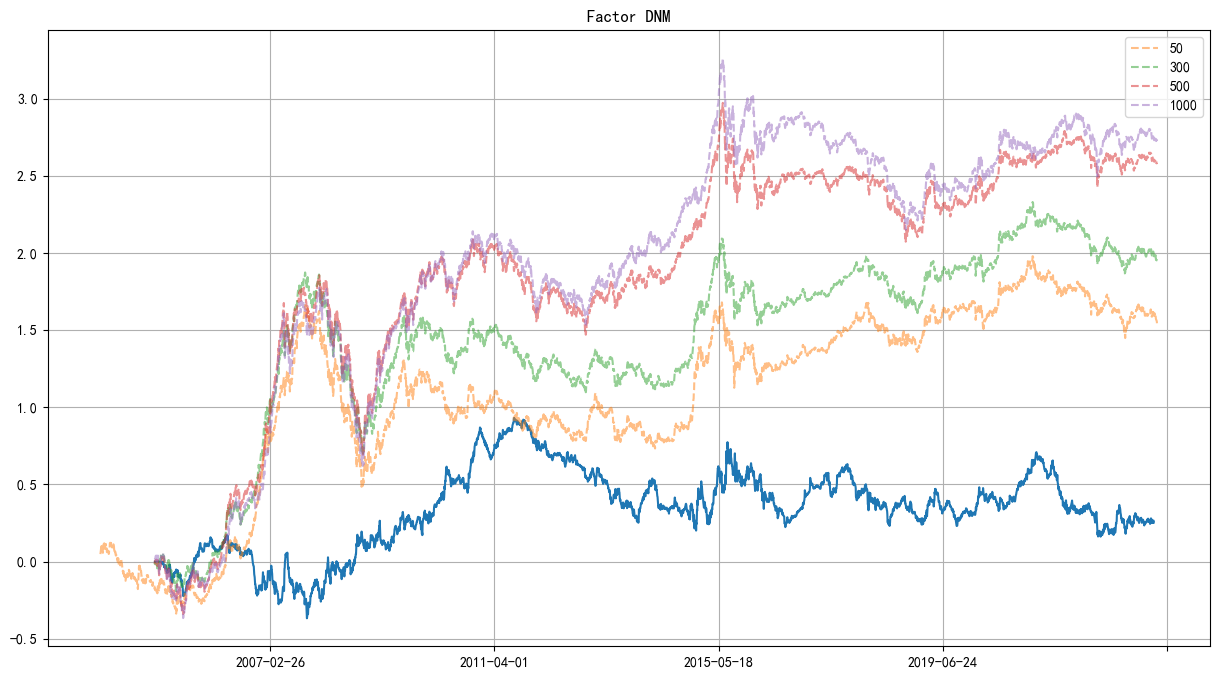

In [1498]:
# 单因子强弱
DNM_select3333, DNM_rets3333 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (ONexR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

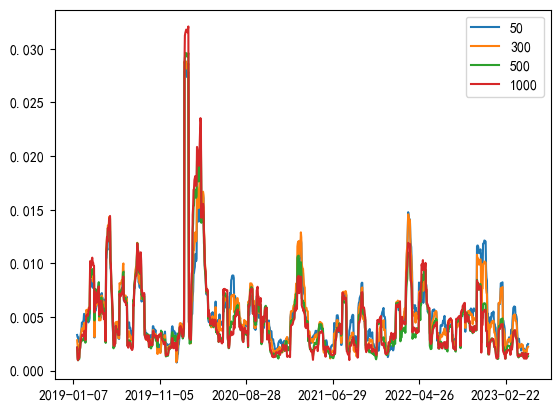

In [1118]:
ON.loc[['50', '300', '500', '1000'],'2019-01-07':].T.rolling(10).std().plot()

In [1335]:
((DN+1)*(ON+1)-1).T[['50', '1000']].dropna()

50      1000
2005-01-05  0.005268  0.023838
2005-01-06 -0.010739 -0.008009
2005-01-07  0.001358  0.006241
2005-01-10  0.011377  0.011760
2005-01-11  0.005852  0.003440
...              ...       ...
2023-05-04  0.005577  0.001586
2023-05-05 -0.002792 -0.011927
2023-05-08  0.013090  0.007341
2023-05-09 -0.006024 -0.013557
2023-05-10 -0.011106  0.002371

[4456 rows x 2 columns]

846.0
yoy: 0.3513827343995113 
 mdd: -0.2884173238919292 
 sharpe: 1.4642162562908296 
 rankIC: 0.06954225352112677 
 rankIR: 0.0696956804061343 
 win%: 0.5345358556973163 
 gain_loss%: -1.1266675119898792


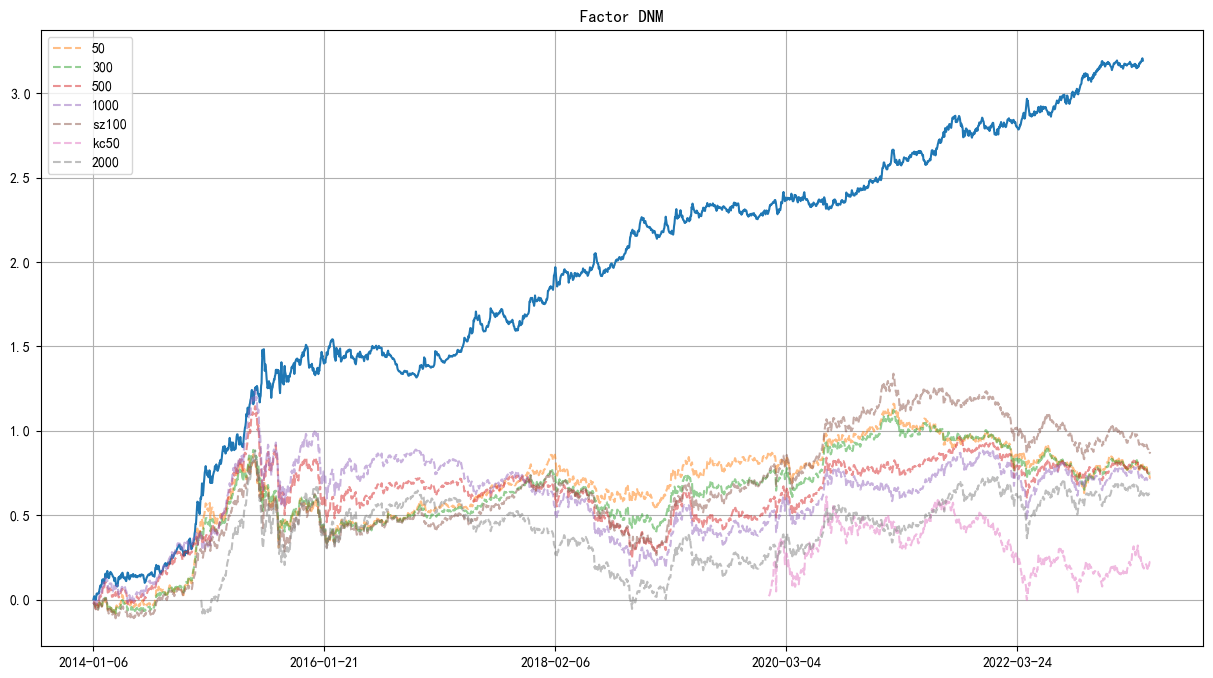

In [1360]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    ((DN+1)*(ON+1)-1).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-04':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,'2014-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)

942.0
yoy: 0.24153346237137158 
 mdd: -0.6871554036180962 
 sharpe: 1.004203139272735 
 rankIC: 0.06514084507042253 
 rankIR: 0.06526512584941217 
 win%: 0.5323361196656401 
 gain_loss%: -1.0478605022576193


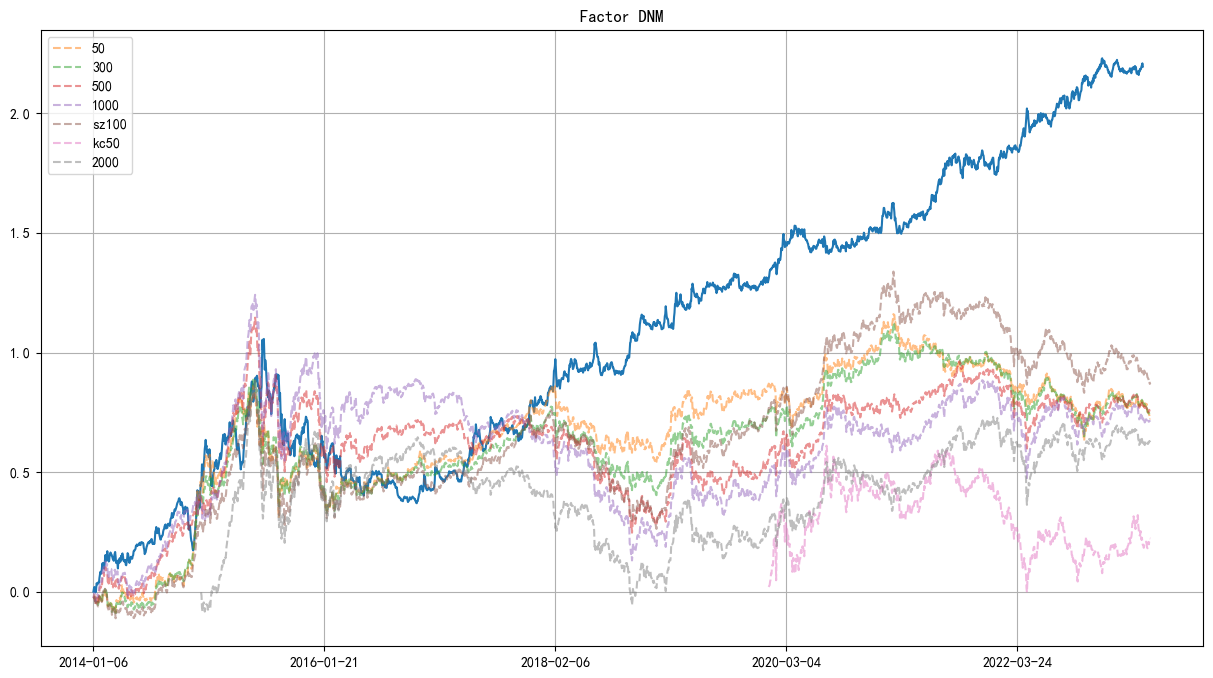

In [1356]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    ((DN)).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-04':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,'2014-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)

866.0
yoy: 0.0876018439100392 
 mdd: -0.7404064300689304 
 sharpe: 0.36354961384511975 
 rankIC: -0.01453104359313078 
 rankIR: -0.014529378008824067 
 win%: 0.4925176056338028 
 gain_loss%: -1.0976775199072943


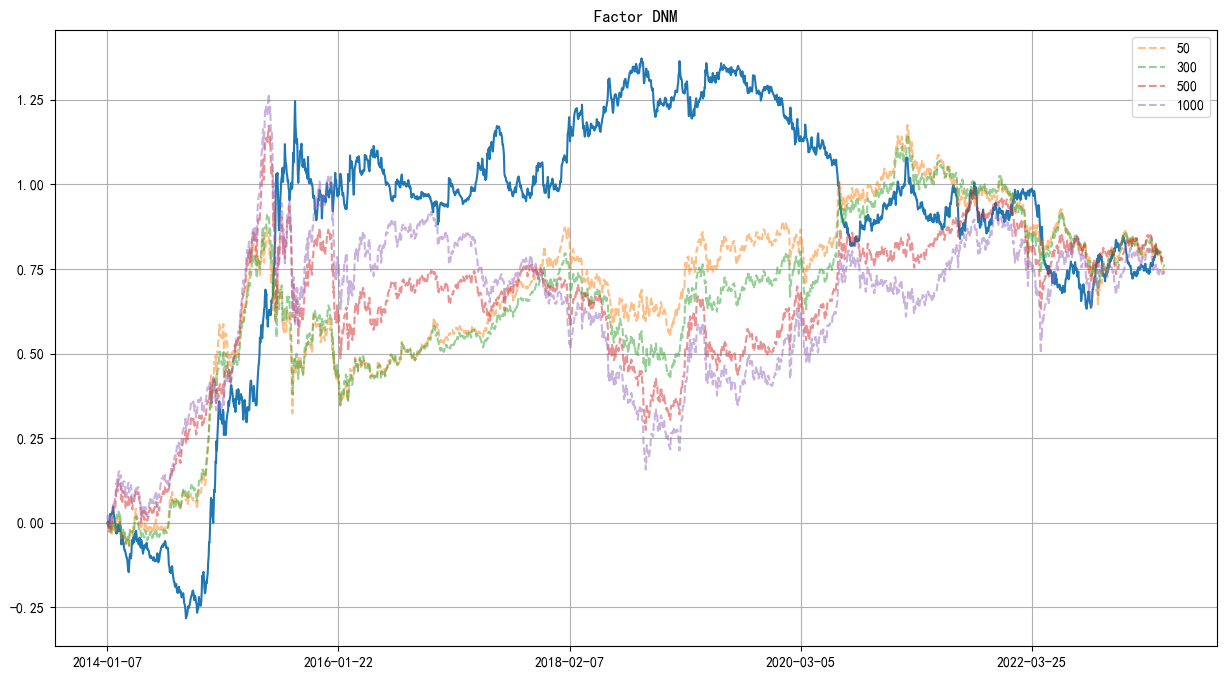

In [1357]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2014-01-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

742.0
yoy: -0.04926781483605097 
 mdd: -1.4018765472712063 
 sharpe: -0.2195617938324593 
 rankIC: -0.07488622258998759 
 rankIR: -0.0750815520662349 
 win%: 0.4602717167558666 
 gain_loss%: -1.1190599872987557


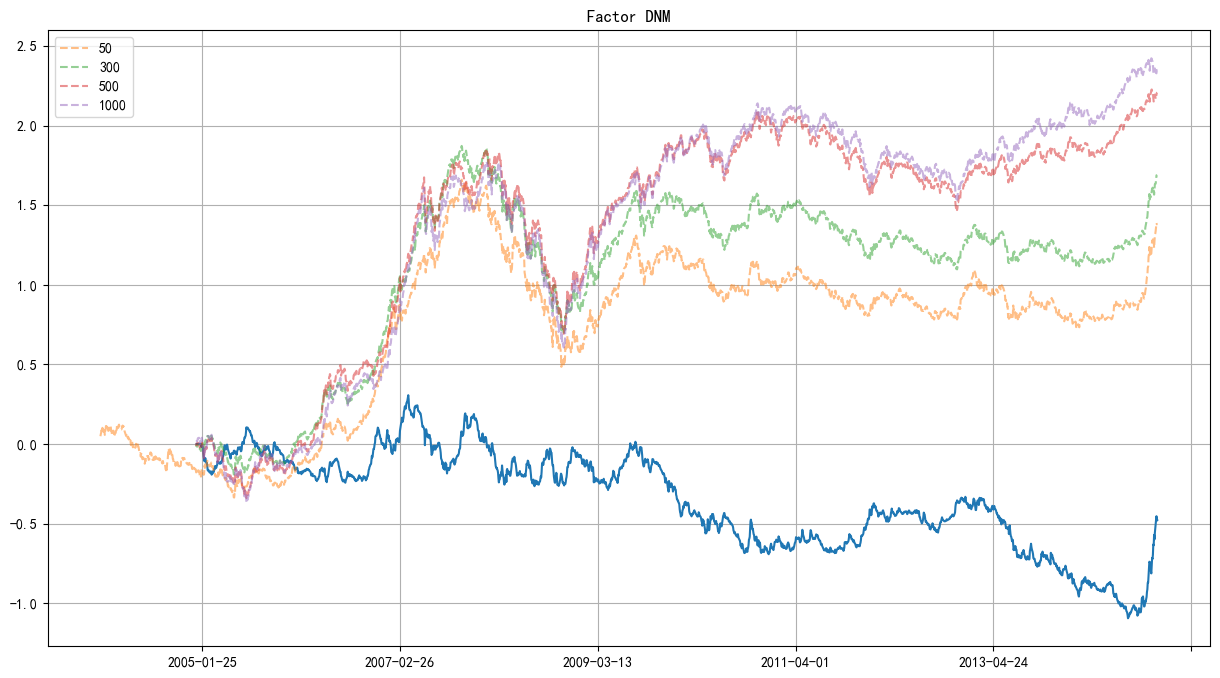

In [1361]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()).T.loc[['50', '1000'],:'2015-01-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

370.0
yoy: 0.4760370006280812 
 mdd: -0.24638318558531214 
 sharpe: 1.7760251494387616 
 rankIC: 0.06140350877192982 
 rankIR: 0.061492606559286185 
 win%: 0.530236634531113 
 gain_loss%: -1.2258417809377462


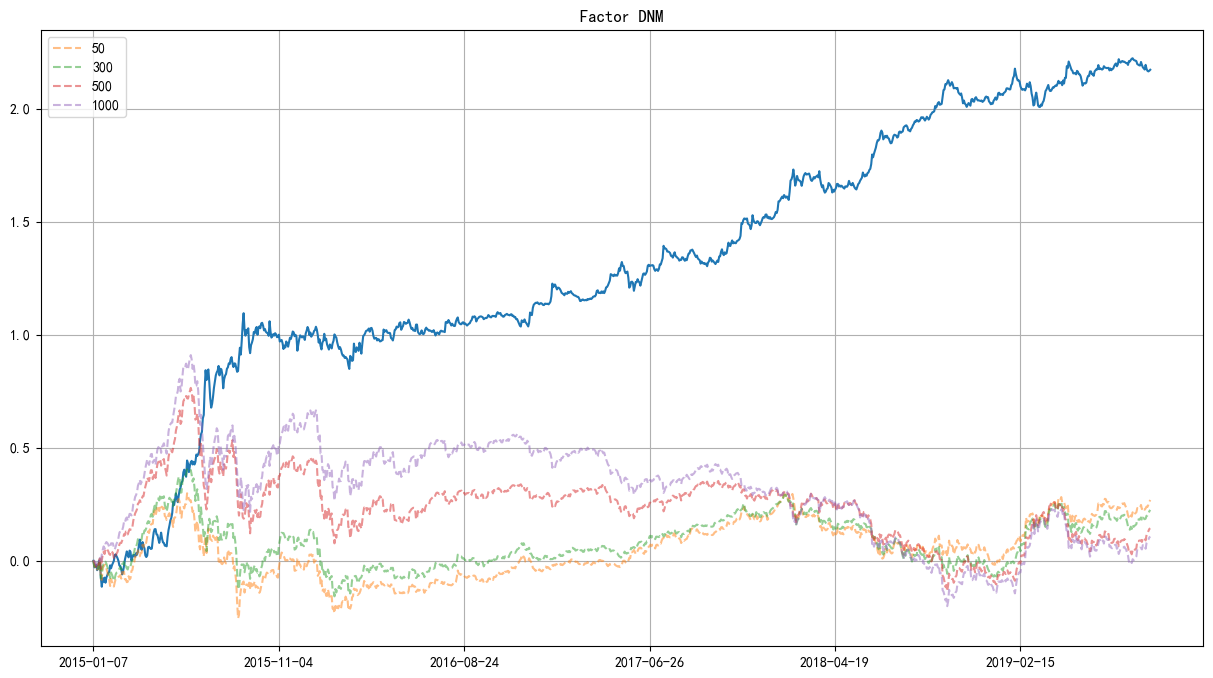

In [1215]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2015-01-07':'2019-09-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [1229]:
xy.Index_rets.loc[['50', '300', '500', '1000'],'2019-09-07':].T.rolling(20).std().mean(axis=1).mean()

0.012208422166900972

In [1228]:
xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'].T.rolling(20).std().mean(axis=1).mean()

0.015153679057534408

In [1227]:
xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'].T.rolling(20).std().mean(axis=1).mean()

0.017127586227849875

370.0
yoy: 0.4760370006280812 
 mdd: -0.24638318558531214 
 sharpe: 1.7760251494387616 
 rankIC: 0.06140350877192982 
 rankIR: 0.061492606559286185 
 win%: 0.530236634531113 
 gain_loss%: -1.2258417809377462


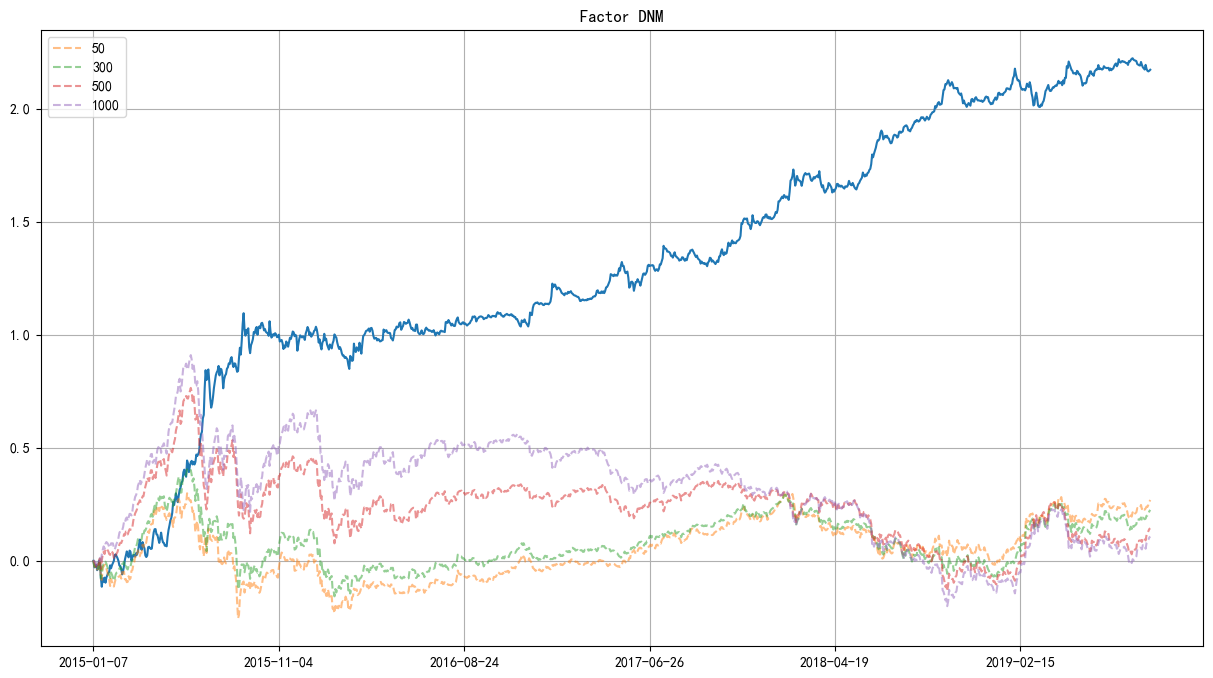

In [1238]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2015-01-07':'2019-09-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

726.0
yoy: -0.08136591776750986 
 mdd: -1.93422046329254 
 sharpe: -0.3626672773931173 
 rankIC: -0.08729830368225072 
 rankIR: -0.08761473678429843 
 win%: 0.45409633594071636 
 gain_loss%: -1.1196229687309598


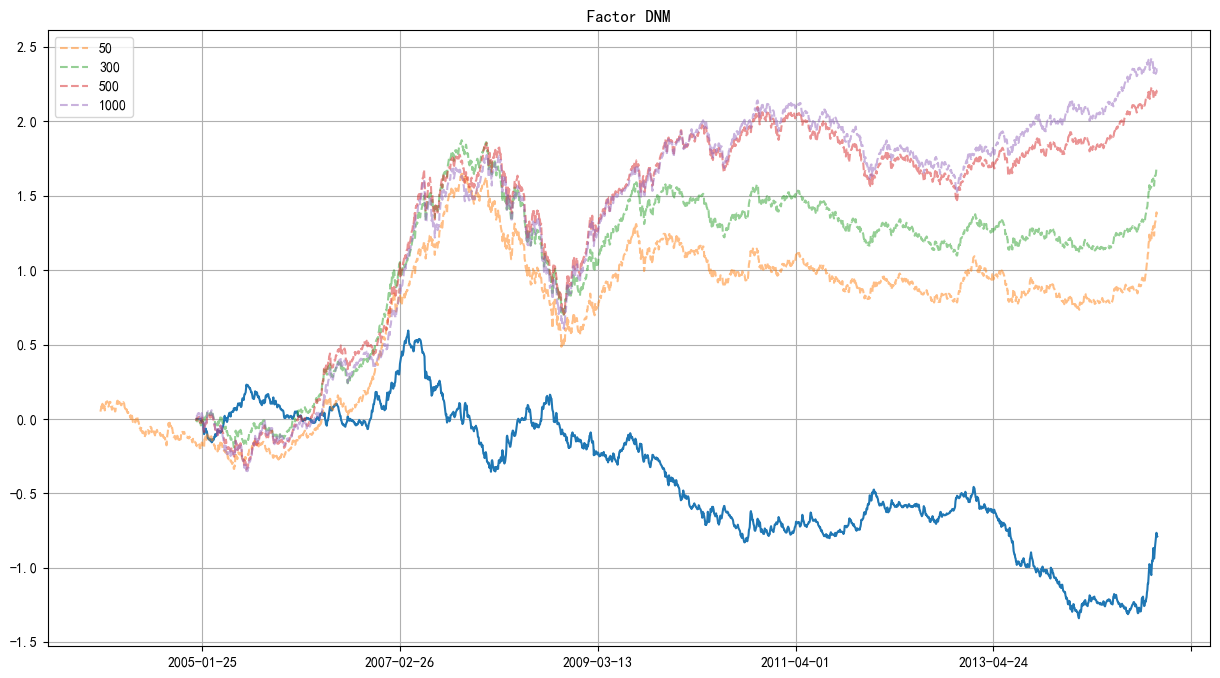

In [1236]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],:'2015-01-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

434.0
yoy: 0.04804421390876315 
 mdd: -0.31357306181221445 
 sharpe: 0.2496711186327396 
 rankIC: -0.009029345372460492 
 rankIR: -0.009024616258300866 
 win%: 0.49492671927846676 
 gain_loss%: -1.0596603055008413


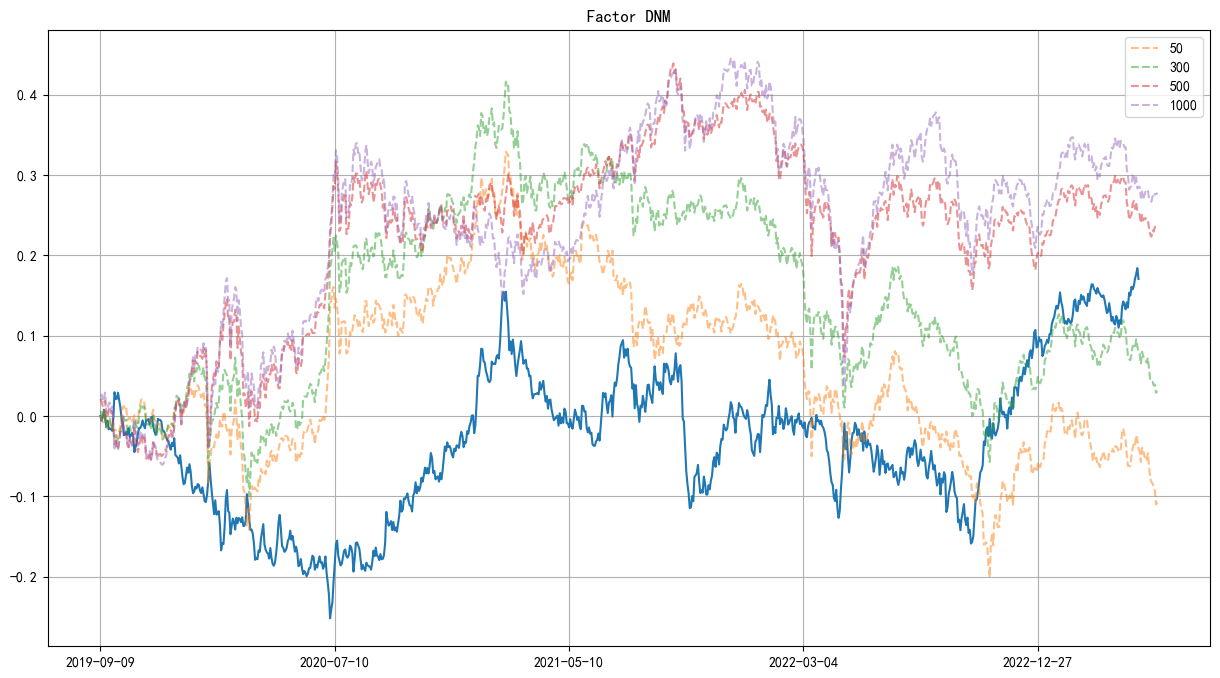

In [1217]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2019-09-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2019-09-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

# TNR

In [507]:
new_idx = []
for i in xy.weights1000.index:
    if i[-2:] == 'SZ':
        new_idx.append(i[:-3]+'.XSHE')
    else:
        new_idx.append(i[:-3]+'.XSHG')

In [507]:
Index_turnover = pd.concat([
    (xy.turns*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (xy.turns*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (xy.turns*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (xy.turns*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).shift(1).T

In [508]:
Index_OrgMom = pd.concat([
    (Orig_Mom*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (Orig_Mom*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (Orig_Mom*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (Orig_Mom*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).T

NameError: name 'Orig_Mom' is not defined

In [509]:
def get_ovn_money_mom(ser):
    # 隔夜成交量,昨日最后5分钟量
    fore_ovn_money = pd.Series(np.nansum(xy.rolling_window(ser.money,5)[235::240],axis=1),ser[::240].index.map(lambda x: str(x)[:10]))

    # 隔夜动量
    open1min50 = ser[::240].open
    close1min50 = ser[239::240].close
    
    open1min50.index = open1min50.index.map(lambda x:str(x)[:10])
    close1min50.index = close1min50.index.map(lambda x:str(x)[:10])
    
    ovn_mom = (open1min50/close1min50.shift(1) - 1)
    
    return fore_ovn_money, ovn_mom

In [510]:
def tov_rank(x):
    xrk = x.rank()
    return list(xrk)

In [525]:
def inraday_mom(
    idx_name,
    Index_turnover,
    ret,
    winsize
):
    TRs1 = []
    TRs2 = []
    TRs3 = []
    TRs4 = []
    TRs5 = []
    dts = []
    for _, win in enumerate(Index_turnover.T[idx_name].rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue
        # print(_-winsize+1,_+1)
        rk = win.rank()
        rt = ret.T[idx_name][_-winsize+1:_+1]
        # print(rt,rk)
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        TRs2.append(rt[(rk >= (winsize/5)+1)&(rk < 2*(winsize/5)+1)].mean())
        TRs3.append(rt[(rk >= 2*(winsize/5)+1)&(rk < 3*(winsize/5)+1)].mean())
        TRs4.append(rt[(rk >= 3*(winsize/5)+1)&(rk < 4*(winsize/5)+1)].mean())
        TRs5.append(rt[rk >= 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts),pd.Series(TRs2,dts),pd.Series(TRs3,dts),pd.Series(TRs4,dts),pd.Series(TRs5,dts)

In [520]:
def inraday_mom_all1(
    tov,
    winsize=20
):
    TRs1 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts)

def inraday_mom_all5(
    tov,
    winsize
):
    TRs5 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs5.append(rt[rk > 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs5,dts)

In [514]:
Index_turnover

2016-01-04  2016-01-05  2016-01-06  2016-01-07  2016-01-08  2016-01-11  \
50           NaN    0.600959    0.838974    0.617363    0.189390    0.900050   
300          NaN    1.007628    1.437774    1.112049    0.340205    1.503850   
500          NaN    1.902806    2.756239    2.310722    0.617138    2.537262   
1000         NaN    2.933784    4.266145    3.541869    0.915307    3.890843   

      2016-01-12  2016-01-13  2016-01-14  2016-01-15  ...  2023-04-21  \
50      0.838224    0.639938    0.594539    0.629346  ...    0.568212   
300     1.382202    1.112555    1.023912    1.176258  ...    1.038712   
500     2.480433    2.081727    1.924720    2.141016  ...    1.923832   
1000    3.434705    3.186065    2.958716    3.295557  ...    2.642596   

      2023-04-24  2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  \
50      0.616512    0.607622    0.612236    0.587706    0.713750    0.791155   
300     1.110620    1.078685    1.090175    1.082236    1.011513    1.097057   
500     2.077550    1.889620    2.050606    2.010266    1.799874    2.094879   
1000    2.892163    2.541050    2.749359    2.813959    2.564290    2.758610   

      2023-05-05  2023-05-08  2023-05-09  
50      0.777305    0.673331    0.785555  
300     1.110722    0.998388    1.118519  
500     2.147044    1.941753    1.923458  
1000    2.815287    2.584097    2.614560  

[4 rows x 1785 columns]

In [527]:
trs50_1,trs50_2,trs50_3,trs50_4,trs50_5 = inraday_mom('50',Index_turnover,xy.Index_rets.loc[:,Index_turnover.columns],20)
trs300_1,trs300_2,trs300_3,trs300_4,trs300_5 = inraday_mom('300',Index_turnover,xy.Index_rets.loc[:,Index_turnover.columns],20)
trs500_1,trs500_2,trs500_3,trs500_4,trs500_5 = inraday_mom('500',Index_turnover,xy.Index_rets.loc[:,Index_turnover.columns],20)
trs1000_1,trs1000_2,trs1000_3,trs1000_4,trs1000_5 = inraday_mom('1000',Index_turnover,xy.Index_rets.loc[:,Index_turnover.columns],20)

In [528]:
TSR5 = pd.concat([
    trs50_5.rename('50'),
    trs300_5.rename('300'),
    trs500_5.rename('500'),
    trs1000_5.rename('1000')
],axis=1).T

TSR1 = pd.concat([
    trs50_1.rename('50'),
    trs300_1.rename('300'),
    trs500_1.rename('500'),
    trs1000_1.rename('1000')
],axis=1).T

New_TSR = (TSR5 - TSR5.mean())/TSR5.std() - (TSR1 - TSR1.mean())/TSR1.std()

### 隔夜动量

#### 计算

In [533]:
fore_ovn_money50, ovn_mom50 = get_ovn_money_mom(xy.IndexMin50jq)
fore_ovn_money300, ovn_mom300 = get_ovn_money_mom(xy.IndexMin300jq)
fore_ovn_money500, ovn_mom500 = get_ovn_money_mom(xy.IndexMin500jq)
fore_ovn_money1000, ovn_mom1000 = get_ovn_money_mom(xy.IndexMin1000jq)

In [535]:
fore_ovn_money = pd.concat([
    fore_ovn_money50.rename('50'),
    fore_ovn_money300.rename('300'),
    fore_ovn_money500.rename('500'),
    fore_ovn_money1000.rename('1000')
],axis=1).shift(1).T

In [538]:
fore_ovn_mom = pd.concat([
    ovn_mom50.rename('50'),
    ovn_mom300.rename('300'),
    ovn_mom500.rename('500'),
    ovn_mom1000.rename('1000')
],axis=1).T

In [539]:
ovn_trs50_1,ovn_trs50_2,ovn_trs50_3,ovn_trs50_4,ovn_trs50_5 = inraday_mom('50',fore_ovn_money,fore_ovn_mom,20)
ovn_trs300_1,ovn_trs300_2,ovn_trs300_3,ovn_trs300_4,ovn_trs300_5 = inraday_mom('300',fore_ovn_money,fore_ovn_mom,20)
ovn_trs500_1,ovn_trs500_2,ovn_trs500_3,ovn_trs500_4,ovn_trs500_5 = inraday_mom('500',fore_ovn_money,fore_ovn_mom,20)
ovn_trs1000_1,ovn_trs1000_2,ovn_trs1000_3,ovn_trs1000_4,ovn_trs1000_5 = inraday_mom('1000',fore_ovn_money,fore_ovn_mom,20)

In [541]:
ovn_TSR5 = pd.concat([
    ovn_trs50_5.rename('50'),
    ovn_trs300_5.rename('300'),
    ovn_trs500_5.rename('500'),
    ovn_trs1000_5.rename('1000')
],axis=1).T

ovn_TSR1 = pd.concat([
    ovn_trs50_1.rename('50'),
    ovn_trs300_1.rename('300'),
    ovn_trs500_1.rename('500'),
    ovn_trs1000_1.rename('1000')
],axis=1).T

New_ovn_TSR = (ovn_TSR5 - ovn_TSR5.mean())/ovn_TSR5.std() - (ovn_TSR1 - ovn_TSR1.mean())/ovn_TSR1.std()

-0.01859492820663218
1 0.6027785653529912
2 0.9997164729231641
3 0.9997164729231641
4 0.9997164729231641


<Axes: >

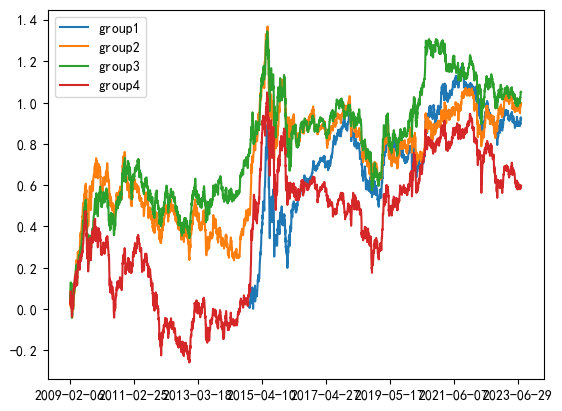

In [542]:
# 分组收益率
xy.cal_rate_group(
    New_ovn_TSR.shift(1,axis=1),
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

#### 多头

shrh: 0.0 win%: 0.5179934569247546 gainloss%: -1.0500771309914925
shrh: 0.2 win%: 0.5184331797235023 gainloss%: -1.0457987586226194
shrh: 0.4 win%: 0.5264452644526445 gainloss%: -1.0940243752413124
shrh: 0.6 win%: 0.5328947368421053 gainloss%: -1.0777997288470291
shrh: 0.8 win%: 0.524024024024024 gainloss%: -1.0639112829064319


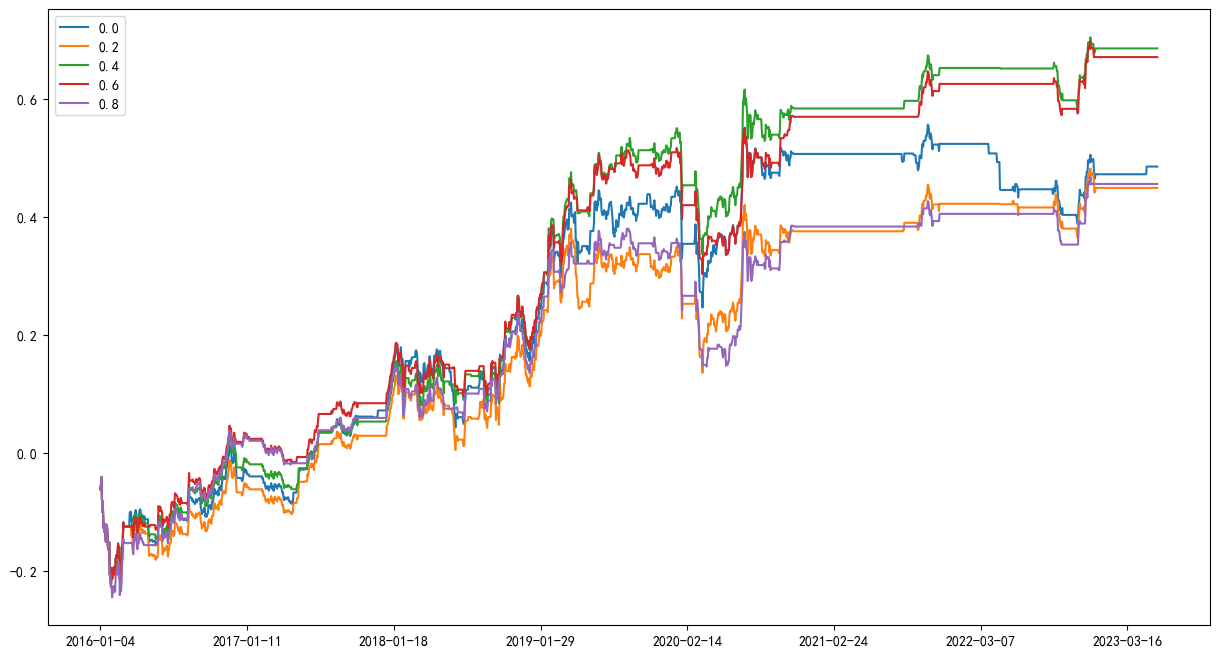

In [241]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]>i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
        
    # if i < 1.4:
    #     continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.8:
        break

In [238]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-01-05    0.007775
2016-01-07   -0.059137
2016-01-08    0.017896
2016-01-11   -0.044773
2016-01-12    0.005251
                ...   
2022-12-07   -0.005288
2022-12-08    0.000842
2022-12-12   -0.012118
2022-12-13    0.001107
2022-12-19   -0.015665
Name: 50, Length: 406, dtype: float64

#### 空头

shrh: 0.0 win%: 0.4976958525345622 gainloss%: -0.9456345567608521
shrh: 0.2 win%: 0.5036585365853659 gainloss%: -0.9324467286715544
shrh: 0.4 win%: 0.5065274151436031 gainloss%: -0.9112198314775933
shrh: 0.6 win%: 0.504297994269341 gainloss%: -0.9124547541108481


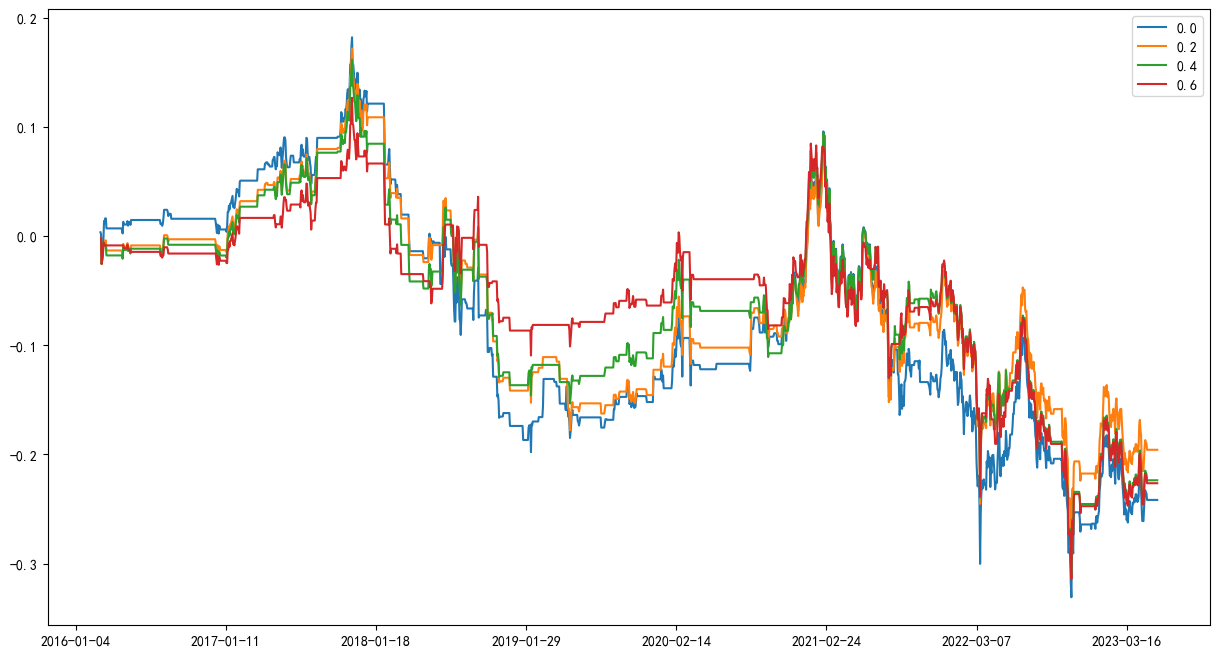

In [239]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]<-i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    
        
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.6:
        break

In [240]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-03-11    0.004498
2016-03-17   -0.002175
2016-05-12    0.003092
2016-05-13   -0.004149
2016-08-02    0.000417
                ...   
2023-04-19   -0.008649
2023-04-25    0.000288
2023-04-26   -0.000479
2023-04-27    0.012449
2023-05-05   -0.002792
Name: 50, Length: 372, dtype: float64

## 评估

### cl-cl

-0.005304542389488867
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

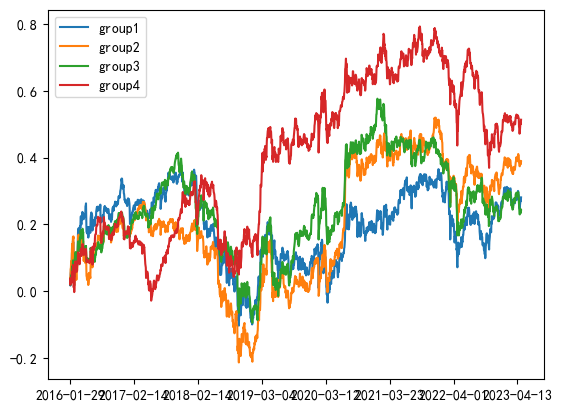

In [532]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1200.0
yoy: 0.13930217658595143 
 mdd: -0.24263911959858697 
 sharpe: 0.8083180496890677 
 rankIC: 0.046514285714285716 
 rankIR: 0.060718360034692116 
 win%: 0.519327731092437 
 gain_loss%: -1.0222420349084191


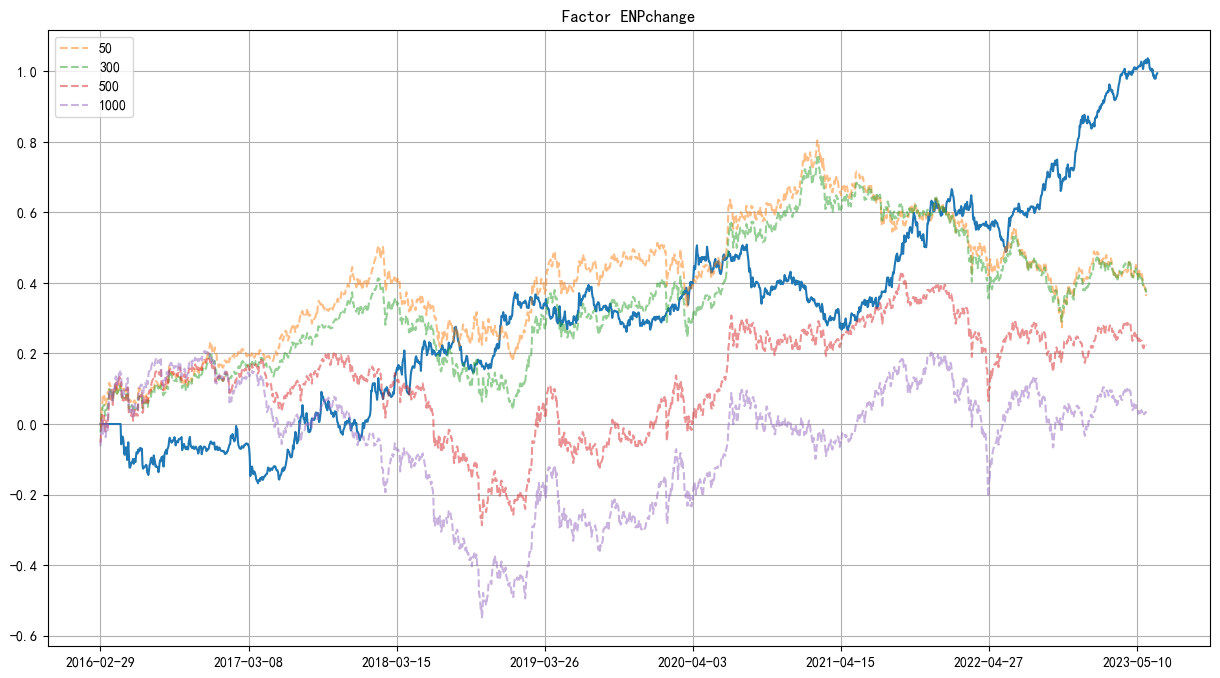

In [523]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx,
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

0.046514285714285716

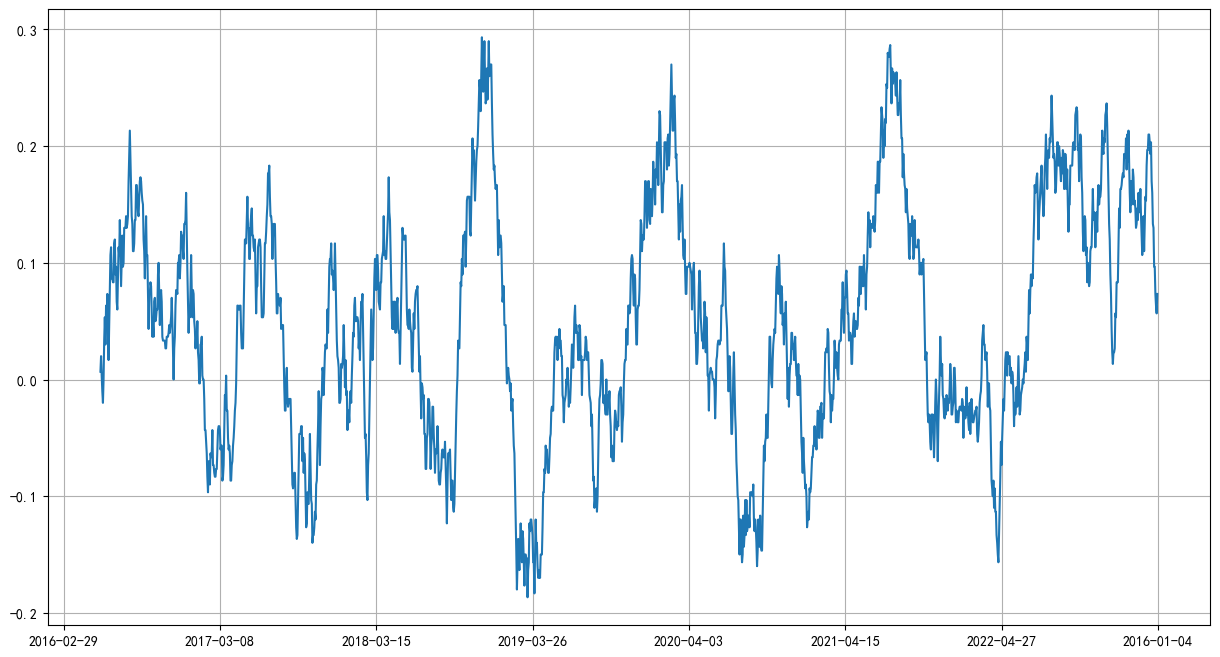

In [493]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### cl_op

-0.05012971921705416
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

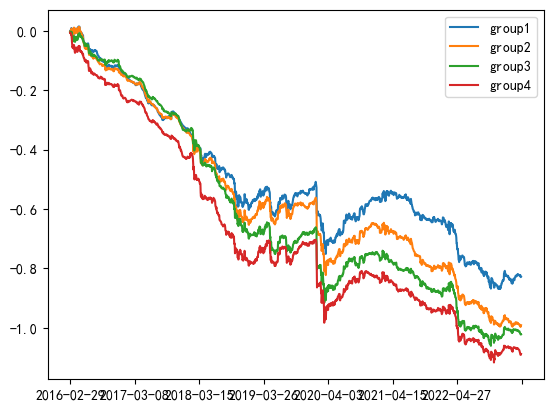

In [524]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1196.0
yoy: -0.037091003278173745 
 mdd: -0.31745989490437765 
 sharpe: -0.772221553049972 
 rankIC: -0.03474285714285715 
 rankIR: -0.0476398609918534 
 win%: 0.47314285714285714 
 gain_loss%: -0.9572870637371589


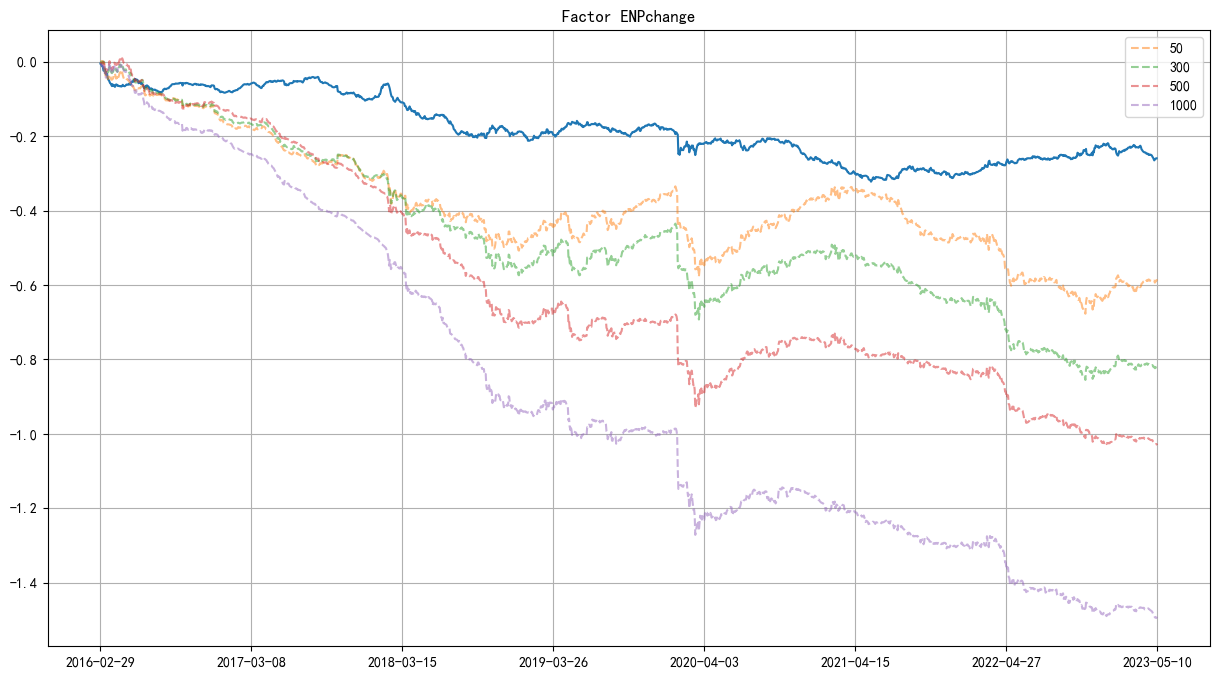

In [525]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

-0.03474285714285715

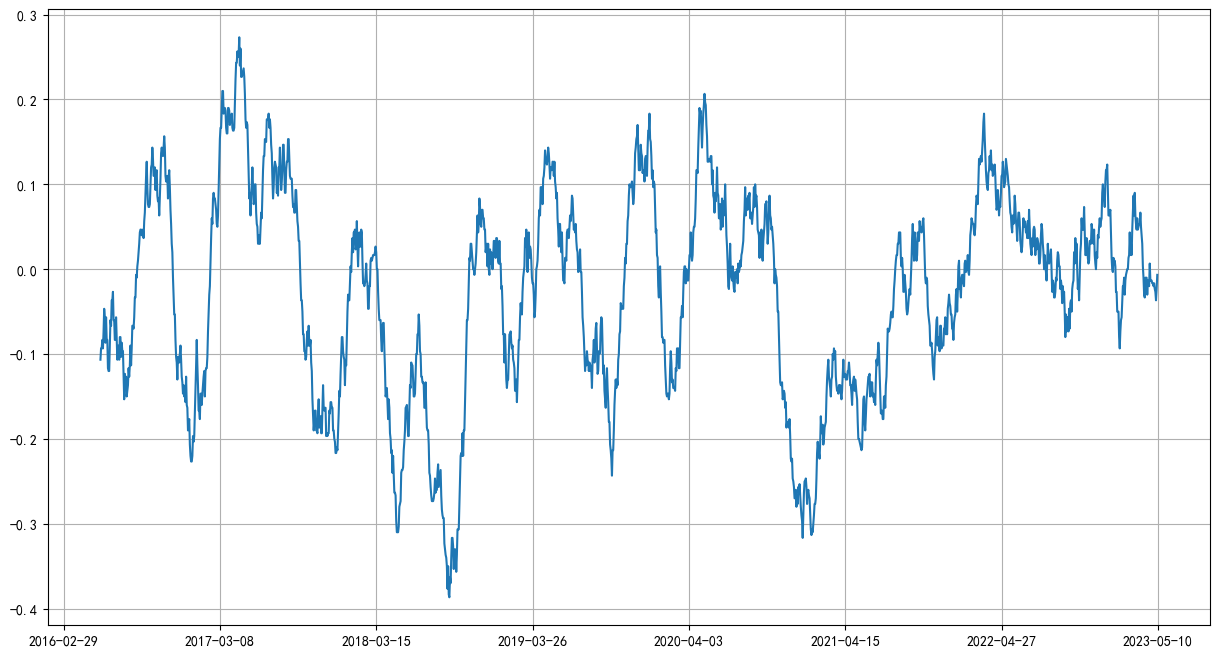

In [526]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

In [311]:
New_TSR

2016-01-29  2016-02-01  2016-02-02  2016-02-03  2016-02-04  2016-02-05  \
50      0.147235    0.226462    1.930968    1.764611    1.508440    1.616129   
300    -0.350651   -0.180354    1.422594    1.234912    1.238376    1.420999   
500     0.305772   -0.170631   -1.830181   -0.871996   -0.627495   -0.971579   
1000   -0.102355    0.124523   -1.523380   -2.127528   -2.119321   -2.065549   

      2016-02-15  2016-02-16  2016-02-17  2016-02-18  ...  2023-04-21  \
50      1.754330    1.857371    1.925839    1.925839  ...   -0.373158   
300     1.132818    0.808581    0.548959    0.548959  ...    0.329314   
500    -0.864574   -2.158523   -2.045980   -2.045980  ...    0.521820   
1000   -2.022574   -0.507429   -0.428817   -0.428817  ...   -0.477975   

      2023-04-24  2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  \
50      0.157809   -0.898556   -0.218572    0.507251    1.803494    2.533228   
300    -0.386280   -0.323111    0.273875   -1.049272   -1.349483   -1.132364   
500     0.278926    1.243249   -0.667052    0.253414   -0.787568   -1.161915   
1000   -0.050455   -0.021582    0.611749    0.288606    0.333557   -0.238948   

      2023-05-05  2023-05-08  2023-05-09  
50      2.403438    2.283654    2.237313  
300    -2.331592   -2.250266   -2.602437  
500    -0.249733   -0.459283    0.304789  
1000    0.177887    0.425895    0.060335  

[4 rows x 1766 columns]

<Axes: >

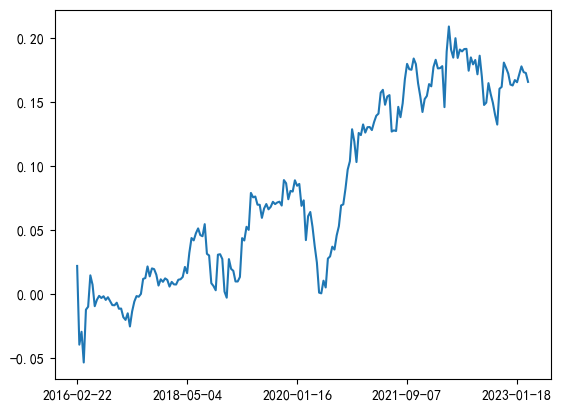

In [317]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']>1.5].index].cumsum().plot()

<Axes: >

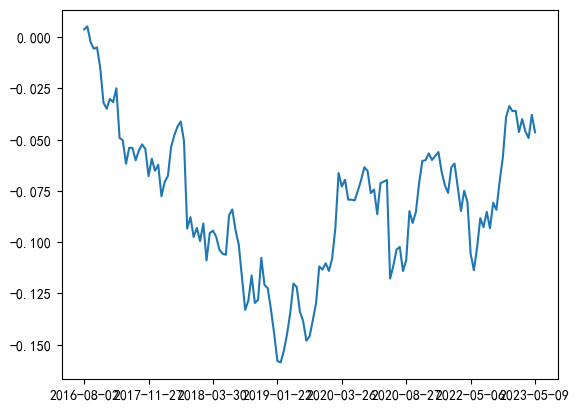

In [318]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']<-1.5].index].cumsum().plot()

In [25]:
ENPchange.to_csv(r'E:\PyProject\factors\NewFactor\st_ENPchg.csv')